# End-to-End Pipeline: Airbnb Dynamic Pricing for Bangkok

This project focuses on building a model to recommend an appropriate price based on market context rather than directly forecasting occupancy rates. It uses the actual prices set by other hosts as market signals to infer a fair and competitive recommended price.

This notebook provides a complete workflow for building a dynamic pricing recommendation system. The process is divided into four phases:

1.  **Phase 1: Data Engineering (DE):** Loading, cleaning, and preparing the raw data.
2.  **Phase 2: Data Analysis (DA):** Exploring the cleaned data to find insights and understand price drivers.
3.  **Phase 3: Data Science (DS):** Training a machine learning model to predict recommended prices and evaluating its performance.
4.  **Phase 4: Inference:** Using the trained model to recommend a price for a new listing.

Target definition (Y): nightly listing price (we also use log-price for modeling), cleaned from outliers and optionally normalized (e.g., price per guest).

### Setup: Import Libraries

First, we import all the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Quick sanity check on columns using the new June drop
DATA_DIR = "data/jun"
LISTING_CANDIDATES = ["listings.csv.gz", "listings.csv"]



# Reusable helper to pick the first existing file in preferred order
def pick_file(name_options, base_dir=DATA_DIR):
    for name in name_options:
        candidate = os.path.join(base_dir, name)
        if os.path.exists(candidate):
            return candidate
    raise FileNotFoundError(f"None of {name_options} found under {base_dir}")



RAW_LISTINGS_PATH = pick_file(LISTING_CANDIDATES)
print(f"Reading listings from: {RAW_LISTINGS_PATH}")
dfdf = pd.read_csv(RAW_LISTINGS_PATH, low_memory=False)
dfdf.columns

Reading listings from: data/jun/listings.csv.gz


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
dfdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28196 entries, 0 to 28195
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            28196 non-null  int64  
 1   listing_url                                   28196 non-null  object 
 2   scrape_id                                     28196 non-null  int64  
 3   last_scraped                                  28196 non-null  object 
 4   source                                        28196 non-null  object 
 5   name                                          28196 non-null  object 
 6   description                                   27430 non-null  object 
 7   neighborhood_overview                         9658 non-null   object 
 8   picture_url                                   28196 non-null  object 
 9   host_id                                       28196 non-null 

--- 
## Phase 1: Data Engineering (DE)

**Goal:** To create a clean, reliable dataset from the raw source files. This involves extracting, transforming, and loading the data.

In [4]:
print("--- Starting Data Engineering Phase ---")

# Reuse helper and base dir (define fallback if this cell is run standalone)
if "DATA_DIR" not in globals():
    DATA_DIR = "data/jun"
if "pick_file" not in globals():
    def pick_file(name_options, base_dir=DATA_DIR):
        for name in name_options:
            candidate = os.path.join(base_dir, name)
            if os.path.exists(candidate):
                return candidate
        raise FileNotFoundError(f"None of {name_options} found under {base_dir}")

RAW_LISTINGS_PATH = pick_file(["listings.csv.gz", "listings.csv"], base_dir=DATA_DIR)
PROCESSED_DATA_DIR = 'processed_data'
PROCESSED_FILE_PATH = os.path.join(PROCESSED_DATA_DIR, 'cleaned_listings.parquet')

# --- 1. EXTRACT: Load Raw Data ---
if not os.path.exists(RAW_LISTINGS_PATH):
    raise FileNotFoundError(f"Raw data not found at '{RAW_LISTINGS_PATH}'. Please ensure the file is in the 'data/jun' directory.")

print(f"Loading raw data from {RAW_LISTINGS_PATH}...")
df_raw = pd.read_csv(
    RAW_LISTINGS_PATH,
    compression='gzip' if RAW_LISTINGS_PATH.endswith('.gz') else None,
    low_memory=False,
 )

# --- 2. TRANSFORM: Clean and Prepare Data ---
print("Transforming and cleaning data...")

# Select a subset of columns to work with
cols_to_keep = [
    'id', 'price', 'neighbourhood_cleansed', 'property_type', 'room_type',
    'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities',
    'number_of_reviews', 'review_scores_rating', 'host_is_superhost',
    'latitude', 'longitude'
 ]
df = df_raw[cols_to_keep].copy()

# a. Clean 'price' column
df['price'] = df['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

# b. Filter out invalid data and extreme outliers
df = df[df['price'] > 0]  # Price must be positive
price_cap = df['price'].quantile(0.995)  # Remove top 0.5% of prices
df = df[df['price'] <= price_cap]


# c. Clean 'bathrooms_text'
def clean_bathrooms(text):
    if pd.isna(text): return np.nan
    if 'half-bath' in text.lower(): return 0.5
    nums = [float(s) for s in text.split() if s.replace('.', '', 1).isdigit()]
    return nums[0] if nums else np.nan

df['bathrooms'] = df['bathrooms_text'].apply(clean_bathrooms)

# d. Basic hygiene: duplicates and plausibility filters
df = df.drop_duplicates(subset='id')
df = df[df['accommodates'] > 0]
df = df[df['beds'] > 0]

# e. Engineer amenity and review signals
df['amenities_count'] = df['amenities'].apply(lambda x: 0 if pd.isna(x) else len(x.split(',')))
df['log_amenities_count'] = np.log1p(df['amenities_count'])
df['log_number_of_reviews'] = np.log1p(df['number_of_reviews'].clip(lower=0))
accommodates_safe = df['accommodates'].replace({0: np.nan})
bedrooms_safe = df['bedrooms'].replace({0: np.nan})
df['beds_per_guest'] = df['beds'] / accommodates_safe
df['bedrooms_per_guest'] = df['bedrooms'] / accommodates_safe
df['bathrooms_per_guest'] = df['bathrooms'] / accommodates_safe
df['amenities_per_guest'] = df['amenities_count'] / accommodates_safe
df['bathrooms_per_bedroom'] = df['bathrooms'] / bedrooms_safe

# f. Geo centering (for later distance-like features)
LAT_MEAN = df['latitude'].mean()
LON_MEAN = df['longitude'].mean()
df['lat_centered'] = df['latitude'] - LAT_MEAN
df['lon_centered'] = df['longitude'] - LON_MEAN

# g. Impute missing numeric values with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# h. Final cleanup
df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
df = df.drop(columns=['bathrooms_text', 'amenities'])  # Drop original complex columns
df.dropna(subset=['property_type', 'room_type'], inplace=True)  # Drop rows where key categoricals are null

# --- 3. LOAD: Save the Cleaned Data (Best Practice) ---
print("Saving cleaned data for future use...")
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
df.to_parquet(PROCESSED_FILE_PATH, index=False)

print("Data Engineering phase complete!")
print(f"Cleaned data shape: {df.shape}")
print(f"Cleaned data saved to: {PROCESSED_FILE_PATH}")
df.head()

--- Starting Data Engineering Phase ---
Loading raw data from data/jun/listings.csv.gz...
Transforming and cleaning data...
Saving cleaned data for future use...
Data Engineering phase complete!
Cleaned data shape: (22084, 24)
Cleaned data saved to: processed_data/cleaned_listings.parquet


/var/folders/b6/28cdp6ds16786vjhx3pz3jlr0000gn/T/ipykernel_10880/3105661165.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,id,price,neighbourhood,property_type,room_type,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,...,amenities_count,log_amenities_count,log_number_of_reviews,beds_per_guest,bedrooms_per_guest,bathrooms_per_guest,amenities_per_guest,bathrooms_per_bedroom,lat_centered,lon_centered
0,27934,1625.0,Ratchathewi,Entire condo,Entire home/apt,2,1.0,1.0,65,4.86,...,25,3.258097,4.189655,0.5,0.5,0.75,12.5,1.500000,0.015343,-0.023039
3,47516,4266.0,Don Mueang,Entire home,Entire home/apt,1,4.0,1.0,0,4.85,...,9,2.302585,0.000000,1.0,4.0,0.50,9.0,1.000000,0.182773,0.020911
4,48736,1477.0,Rat Burana,Private room in rental unit,Private room,2,1.0,1.0,1,5.00,...,30,3.433987,0.693147,0.5,0.5,0.50,15.0,1.000000,-0.058927,-0.069029
5,55681,1354.0,Bang Rak,Private room in serviced apartment,Private room,2,1.0,1.0,38,4.81,...,21,3.091042,3.663562,0.5,0.5,0.50,10.5,1.000000,-0.025147,-0.046779
8,105042,5704.0,Khlong Toei,Entire rental unit,Entire home/apt,5,3.0,3.0,147,4.77,...,31,3.465736,4.997212,0.6,0.6,0.70,6.2,1.166667,-0.010707,-0.001349


### Enrich with calendar/reviews/detail data
Add demand and availability signals from calendar, detailed listings, and review history to strengthen pricing features.

In [5]:
# Calendar + reviews + listing detail enrichment
DATA_DIR = globals().get("DATA_DIR", "data/jun")
if "pick_file" not in globals():
    def pick_file(name_options, base_dir=DATA_DIR):
        for name in name_options:
            candidate = os.path.join(base_dir, name)
            if os.path.exists(candidate):
                return candidate
        raise FileNotFoundError(f"None of {name_options} found under {base_dir}")

def read_csv_maybe_gzip(path):
    return pd.read_csv(path, low_memory=False, compression="gzip" if path.endswith('.gz') else None)

CALENDAR_PATH = pick_file(["calendar.csv", "calendar.csv.gz"], base_dir=DATA_DIR)
LISTINGS_DETAIL_PATH = pick_file(["listings_detail.csv", "listings_detail.csv.gz"], base_dir=DATA_DIR)
REVIEWS_DETAIL_PATH = pick_file(["reviews_detail.csv", "reviews_detail.csv.gz"], base_dir=DATA_DIR)

# Remove previously merged enrichment columns to avoid suffix clutter
enriched_prefixes = (
    'median_price_90', 'booked_rate_90', 'price_cv_90', 'weekend_price_ratio',
    'review_count_90', 'review_count_365', 'days_since_last_review',
    'host_total_listings_count', 'minimum_nights', 'maximum_nights',
    'review_scores_mean', 'review_scores_std', 'high_rating_flag',
    'cleanliness_minus_overall', 'amenities_detail_count',
    'peak_month_booked_rate', 'booked_rate_std_monthly', 'peak_month', 'avail_rate_90'
)
cols_to_drop = [c for c in df.columns if c.startswith(enriched_prefixes)]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Load external tables
calendar = read_csv_maybe_gzip(CALENDAR_PATH)
listings_detail = read_csv_maybe_gzip(LISTINGS_DETAIL_PATH)
reviews_detail = read_csv_maybe_gzip(REVIEWS_DETAIL_PATH)

# Harmonize ID types (avoid mismatched merges)
for frame, col in [
    (calendar, 'listing_id'),
    (listings_detail, 'id'),
    (reviews_detail, 'listing_id')
 ]:
    frame[col] = pd.to_numeric(frame[col], errors='coerce')
    frame.dropna(subset=[col], inplace=True)
    frame[col] = frame[col].astype(int)

df['id'] = pd.to_numeric(df['id'], errors='coerce').astype(int)

# Helper: clean Airbnb-style price strings
price_cleaner = lambda s: pd.to_numeric(
    pd.Series(s).astype(str).str.replace(r'[\$,]', '', regex=True), errors='coerce'
 )

# --- Calendar features (recent 90 days) ---
calendar['price'] = price_cleaner(calendar['price']).values
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['available_flag'] = calendar['available'].astype(str).str.lower().eq('t')
calendar['is_weekend'] = calendar['date'].dt.dayofweek.isin([4, 5]).astype(int)
calendar['month_period'] = calendar['date'].dt.to_period('M')

# max_cal_date = calendar['date'].max()
# cal_recent = calendar[calendar['date'] >= max_cal_date - pd.Timedelta(days=90)].copy()
min_cal_date = calendar['date'].min() 

# Filter for the NEXT 90 days from the scrape date
cal_recent = calendar[
    (calendar['date'] >= min_cal_date) & 
    (calendar['date'] < min_cal_date + pd.Timedelta(days=90))
].copy()


cal_agg = cal_recent.groupby('listing_id').agg(
    median_price_90=('price', 'median'),
    avail_rate_90=('available_flag', 'mean'),
    price_cv_90=('price', lambda s: s.std(ddof=0) / s.mean() if s.mean() else np.nan),
).reset_index()
cal_agg['booked_rate_90'] = 1 - cal_agg['avail_rate_90']

weekend_price = cal_recent[cal_recent['is_weekend'] == 1].groupby('listing_id')['price'].mean()
cal_agg['weekend_price_ratio'] = (
    weekend_price.reindex(cal_agg['listing_id']).values
    / cal_agg['median_price_90'].replace(0, np.nan)
)

monthly = cal_recent.groupby(['listing_id', 'month_period']).agg(
    booked_rate_month=('available_flag', lambda x: 1 - x.mean())
).reset_index()
peak_idx = monthly.groupby('listing_id')['booked_rate_month'].idxmax()
peak = monthly.loc[peak_idx, ['listing_id', 'month_period', 'booked_rate_month']].rename(
    columns={'month_period': 'peak_month', 'booked_rate_month': 'peak_month_booked_rate'}
)
booked_rate_std = monthly.groupby('listing_id')['booked_rate_month'].std().reset_index().rename(
    columns={'booked_rate_month': 'booked_rate_std_monthly'}
)

# --- Review history features ---
reviews_detail['date'] = pd.to_datetime(reviews_detail['date'])
reviews_detail = reviews_detail.sort_values(['listing_id', 'date'])
today = reviews_detail['date'].max()
review_agg = reviews_detail.groupby('listing_id').agg(
    review_count_90=('date', lambda s: (s >= today - pd.Timedelta(days=90)).sum()),
    review_count_365=('date', lambda s: (s >= today - pd.Timedelta(days=365)).sum()),
    days_since_last_review=('date', lambda s: (today - s.max()).days)
).reset_index()

# --- Listing detail features ---
listings_detail['amenities'] = listings_detail['amenities'].astype(str)
listings_detail['amenities_detail_count'] = listings_detail['amenities'].apply(
    lambda x: 0 if pd.isna(x) else len(x.split(','))
 )
review_score_cols = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
 ]
score_cols_available = [c for c in review_score_cols if c in listings_detail.columns]
if score_cols_available:
    listings_detail['review_scores_mean'] = listings_detail[score_cols_available].mean(axis=1)
    listings_detail['review_scores_std'] = listings_detail[score_cols_available].std(axis=1)
else:
    listings_detail['review_scores_mean'] = np.nan
    listings_detail['review_scores_std'] = np.nan
listings_detail['high_rating_flag'] = (listings_detail.get('review_scores_rating', pd.Series(dtype=float)) >= 4.8).fillna(0).astype(int)
listings_detail['cleanliness_minus_overall'] = listings_detail.get('review_scores_cleanliness', pd.Series(dtype=float)) - listings_detail.get('review_scores_rating', pd.Series(dtype=float))

detail_cols = [
    'id', 'host_total_listings_count', 'minimum_nights', 'maximum_nights',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'review_scores_mean', 'review_scores_std',
    'high_rating_flag', 'cleanliness_minus_overall', 'amenities_detail_count'
 ]
detail_cols = [c for c in detail_cols if c in listings_detail.columns]
listings_detail_subset = listings_detail[detail_cols].rename(columns={'id': 'listing_id'})

# --- Merge all enrichments back to df ---
df = df.merge(cal_agg, left_on='id', right_on='listing_id', how='left').drop(columns=['listing_id'])
df = df.merge(peak, left_on='id', right_on='listing_id', how='left').drop(columns=['listing_id'])
df = df.merge(booked_rate_std, left_on='id', right_on='listing_id', how='left').drop(columns=['listing_id'])
df = df.merge(review_agg, left_on='id', right_on='listing_id', how='left').drop(columns=['listing_id'])
df = df.merge(listings_detail_subset, left_on='id', right_on='listing_id', how='left').drop(columns=['listing_id'])

# Fill missing optional enrichments with medians to keep the model usable
fill_median_cols = [
    'median_price_90', 'booked_rate_90', 'price_cv_90', 'weekend_price_ratio', 'avail_rate_90',
    'peak_month_booked_rate', 'booked_rate_std_monthly', 'review_count_90', 'review_count_365',
    'days_since_last_review', 'host_total_listings_count', 'minimum_nights', 'maximum_nights',
    'review_scores_mean', 'review_scores_std', 'high_rating_flag', 'cleanliness_minus_overall',
    'amenities_detail_count'
 ]
for col in fill_median_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)
if 'peak_month' in df.columns:
    df['peak_month'] = df['peak_month'].astype(str)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/b6/28cdp6ds16786vjhx3pz3jlr0000gn/T/ipykernel_10880/1658365610.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [6]:
# Robust enrichment fix: safe aggregations, no suffix duplicates, clean imputations
import pandas as pd
import numpy as np
from pathlib import Path

# --- Config & reload calendar ---
cal = pd.read_csv(CALENDAR_PATH, low_memory=False)
cal['listing_id'] = pd.to_numeric(cal.get('listing_id'), errors='coerce').astype('Int64')
price_src = 'adjusted_price' if 'adjusted_price' in cal.columns else 'price'
cal[price_src] = cal[price_src].astype(str).str.replace('$','',regex=False).str.replace(',','',regex=False).str.strip()
cal['price_num'] = pd.to_numeric(cal[price_src], errors='coerce')
if 'date' not in cal.columns:
    raise ValueError('calendar.csv missing date column')
cal['date'] = pd.to_datetime(cal['date'], errors='coerce')
cal['available_flag'] = cal.get('available', '').astype(str).str.lower().isin(['t','true','1'])
cal['is_weekend'] = cal['date'].dt.dayofweek.isin([4,5]).astype(int)

# Align df ids
df['id'] = pd.to_numeric(df['id'], errors='coerce').astype('Int64')

# --- 90-day window with fallback ---
last_date = cal['date'].max()
cutoff = last_date - pd.Timedelta(days=90)
cal_recent = cal[cal['date'] >= cutoff]
if cal_recent.empty:
    cal_recent = cal.copy()

# --- Safe aggregations per listing_id ---
grp = cal_recent.groupby('listing_id')
median_price = grp['price_num'].median()
avail_rate = grp['available_flag'].mean()
price_mean = grp['price_num'].mean()
price_std = grp['price_num'].std(ddof=0)
weekend_mean = cal_recent[cal_recent['is_weekend'] == 1].groupby('listing_id')['price_num'].mean()

# Compute derived metrics with guards
booked_rate = 1.0 - avail_rate
price_cv = price_std / price_mean
# Avoid divide-by-zero and NaN cascades
price_cv = price_cv.where((~price_mean.isna()) & (price_mean != 0), np.nan)
weekend_ratio = weekend_mean.reindex(median_price.index) / median_price
weekend_ratio = weekend_ratio.where((~median_price.isna()) & (median_price != 0), np.nan)

agg_recent = pd.DataFrame({
    'listing_id': median_price.index,
    'median_price_90': median_price.values,
    'avail_rate_90': avail_rate.values.astype(float),
    'booked_rate_90': booked_rate.values.astype(float),
    'price_cv_90': price_cv.values.astype(float),
    'weekend_price_ratio': weekend_ratio.values.astype(float)
})

# --- Drop any pre-existing enrichment columns to avoid _x/_y suffix ---
enrich_cols = ['median_price_90','avail_rate_90','booked_rate_90','price_cv_90','weekend_price_ratio']
df = df.drop(columns=[c for c in enrich_cols if c in df.columns])

# Merge enrichment cleanly
df = df.merge(agg_recent, left_on='id', right_on='listing_id', how='left')
df.drop(columns=['listing_id'], inplace=True)

# --- Fill sensible defaults ---
if 'booked_rate_90' in df.columns:
    df['booked_rate_90'] = df['booked_rate_90'].fillna(df['booked_rate_90'].median() if df['booked_rate_90'].notna().any() else 0.5)
if 'median_price_90' in df.columns:
    df['median_price_90'] = df['median_price_90'].fillna(df['price'].median())
if 'price_cv_90' in df.columns:
    df['price_cv_90'] = df['price_cv_90'].replace([np.inf, -np.inf], np.nan).fillna(0.0)
if 'weekend_price_ratio' in df.columns:
    df['weekend_price_ratio'] = df['weekend_price_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)

# --- Review scores: coalesce x/y into a single rating and impute ---
if ('review_scores_rating_x' in df.columns) or ('review_scores_rating_y' in df.columns):
    df['review_scores_rating'] = df.get('review_scores_rating_x').where(df.get('review_scores_rating_x').notna(), df.get('review_scores_rating_y'))
    df.drop(columns=[c for c in ['review_scores_rating_x','review_scores_rating_y'] if c in df.columns], inplace=True)

review_cols = [c for c in df.columns if c.startswith('review_scores_') and c not in ['review_scores_mean','review_scores_std']]
if review_cols:
    row_mean = df[review_cols].mean(axis=1)
    for c in review_cols:
        df[c] = df[c].fillna(row_mean)
    for c in review_cols:
        df[c] = df[c].fillna(df[c].median())

# --- Superhost mapping ---
if 'host_is_superhost' in df.columns:
    df['host_is_superhost'] = (
        df['host_is_superhost']
          .astype(str)
          .str.lower()
          .map({'t':1,'true':1,'1':1,'f':0,'false':0,'0':0})
          .fillna(0)
          .astype(int)
    )

print('Enrichment fix complete (robust).')
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print('Remaining missingness (top 12):')
print(missing_pct.head(12).round(2))


Enrichment fix complete (robust).
Remaining missingness (top 12):
id                             0.0
booked_rate_std_monthly        0.0
review_count_365               0.0
days_since_last_review         0.0
host_total_listings_count      0.0
minimum_nights                 0.0
maximum_nights                 0.0
review_scores_accuracy         0.0
review_scores_cleanliness      0.0
review_scores_checkin          0.0
review_scores_communication    0.0
review_scores_location         0.0
dtype: float64


In [7]:
# Quick data snapshot after enrichment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("Rows, columns:", df.shape)
print("Columns:")
print(df.columns.tolist())

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("\nTop missingness (%):")
print(missing_pct.head(12).round(2))

print("\nHead:")
display(df.head())

Rows, columns: (22084, 49)
Columns:
['id', 'price', 'neighbourhood', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'host_is_superhost', 'latitude', 'longitude', 'bathrooms', 'amenities_count', 'log_amenities_count', 'log_number_of_reviews', 'beds_per_guest', 'bedrooms_per_guest', 'bathrooms_per_guest', 'amenities_per_guest', 'bathrooms_per_bedroom', 'lat_centered', 'lon_centered', 'peak_month', 'peak_month_booked_rate', 'booked_rate_std_monthly', 'review_count_90', 'review_count_365', 'days_since_last_review', 'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'review_scores_mean', 'review_scores_std', 'high_rating_flag', 'cleanliness_minus_overall', 'amenities_detail_count', 'median_price_90', 'avail_rate_90', 'booked_rate_90', 'price_cv_90', 'weekend_price_ratio', 'review_

,id,price,neighbourhood,property_type,room_type,accommodates,bedrooms,beds,number_of_reviews,host_is_superhost,latitude,longitude,bathrooms,amenities_count,log_amenities_count,log_number_of_reviews,beds_per_guest,bedrooms_per_guest,bathrooms_per_guest,amenities_per_guest,bathrooms_per_bedroom,lat_centered,lon_centered,peak_month,peak_month_booked_rate,booked_rate_std_monthly,review_count_90,review_count_365,days_since_last_review,host_total_listings_count,minimum_nights,maximum_nights,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_scores_mean,review_scores_std,high_rating_flag,cleanliness_minus_overall,amenities_detail_count,median_price_90,avail_rate_90,booked_rate_90,price_cv_90,weekend_price_ratio,review_scores_rating
0,27934,1625.0,Ratchathewi,Entire condo,Entire home/apt,2,1.0,1.0,65,0,13.75983,100.54134,1.5,25,3.258097,4.189655,0.5,0.5,0.75,12.5,1.500000,0.015343,-0.023039,2025-06,0.600000,0.300000,0.0,1.0,289.0,2.0,15,240,4.95,4.82,4.97,4.91,4.66,4.75,4.845714,0.111782,1,-0.04,25,1350.0,1.0,0.0,0.0,1.0,4.86
1,47516,4266.0,Don Mueang,Entire home,Entire home/apt,1,4.0,1.0,0,0,13.92726,100.58529,1.0,9,2.302585,0.000000,1.0,4.0,0.50,9.0,1.000000,0.182773,0.020911,2025-06,0.000000,0.000000,1.0,4.0,77.0,2.0,3,730,4.85,4.85,4.85,4.85,4.85,4.85,4.832857,0.111612,0,0.00,9,1350.0,1.0,0.0,0.0,1.0,4.85
2,48736,1477.0,Rat Burana,Private room in rental unit,Private room,2,1.0,1.0,1,0,13.68556,100.49535,1.0,30,3.433987,0.693147,0.5,0.5,0.50,15.0,1.000000,-0.058927,-0.069029,2025-06,0.000000,0.000000,0.0,0.0,4168.0,1.0,14,365,5.00,5.00,5.00,5.00,5.00,5.00,5.000000,0.000000,1,0.00,30,1350.0,1.0,0.0,0.0,1.0,5.00
3,55681,1354.0,Bang Rak,Private room in serviced apartment,Private room,2,1.0,1.0,38,1,13.71934,100.51760,1.0,21,3.091042,3.663562,0.5,0.5,0.50,10.5,1.000000,-0.025147,-0.046779,2025-06,0.200000,0.100000,0.0,4.0,125.0,10.0,2,365,4.73,4.84,4.84,4.89,4.78,4.81,4.814286,0.050615,1,0.03,21,1350.0,1.0,0.0,0.0,1.0,4.81
4,105042,5704.0,Khlong Toei,Entire rental unit,Entire home/apt,5,3.0,3.0,147,0,13.73378,100.56303,3.5,31,3.465736,4.997212,0.6,0.6,0.70,6.2,1.166667,-0.010707,-0.001349,2025-07,0.096774,0.055873,0.0,0.0,2004.0,9.0,28,365,4.84,4.85,4.86,4.89,4.86,4.76,4.832857,0.048892,0,0.08,31,1350.0,1.0,0.0,0.0,1.0,4.77


### Feature checks: before vs after cleanup
Quick snapshots to see how cleaning changed key features (distributions, missingness, and top categories).

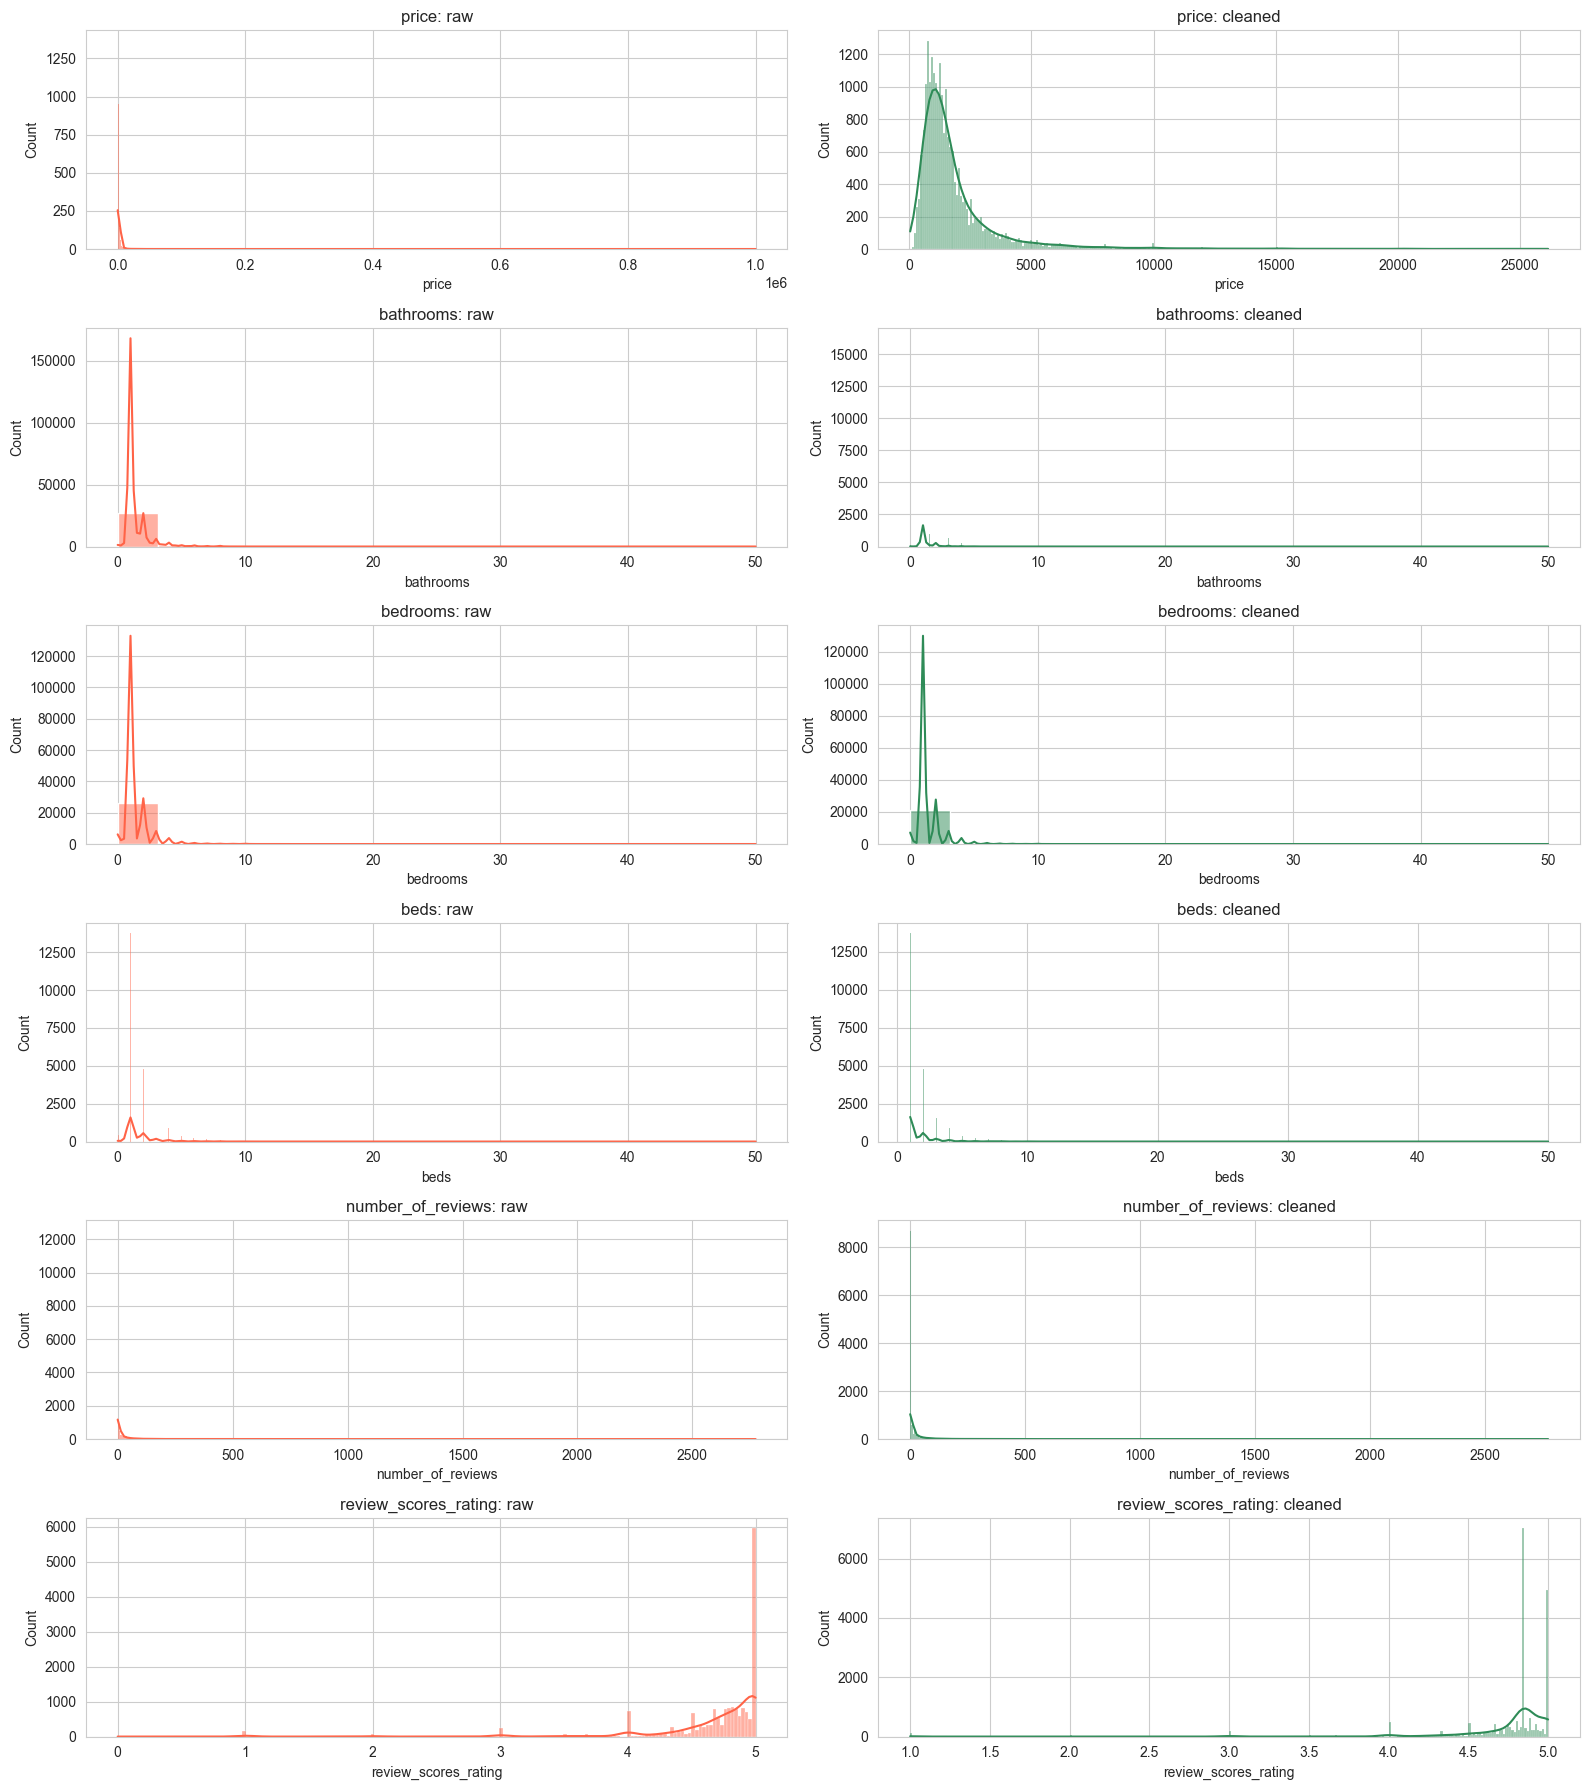

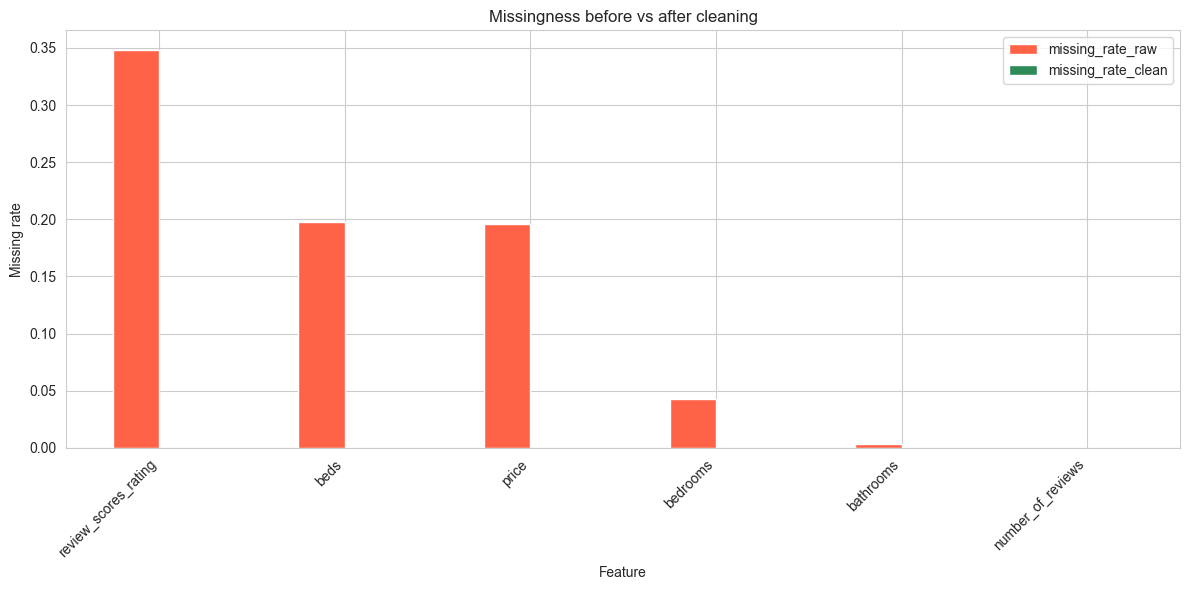

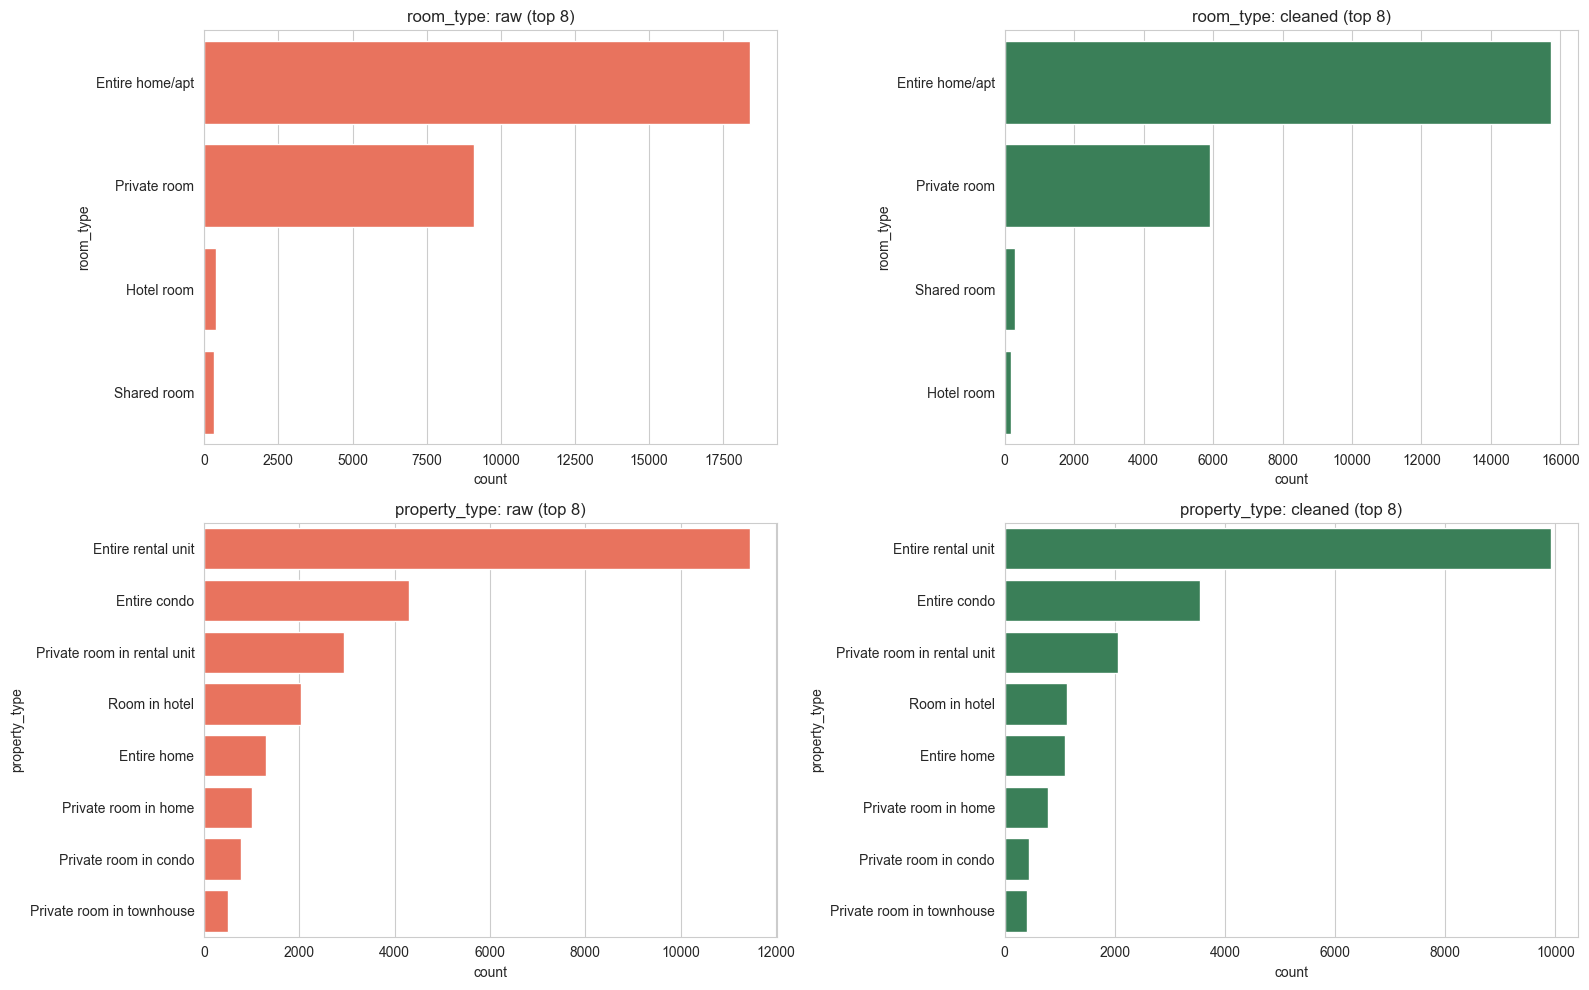

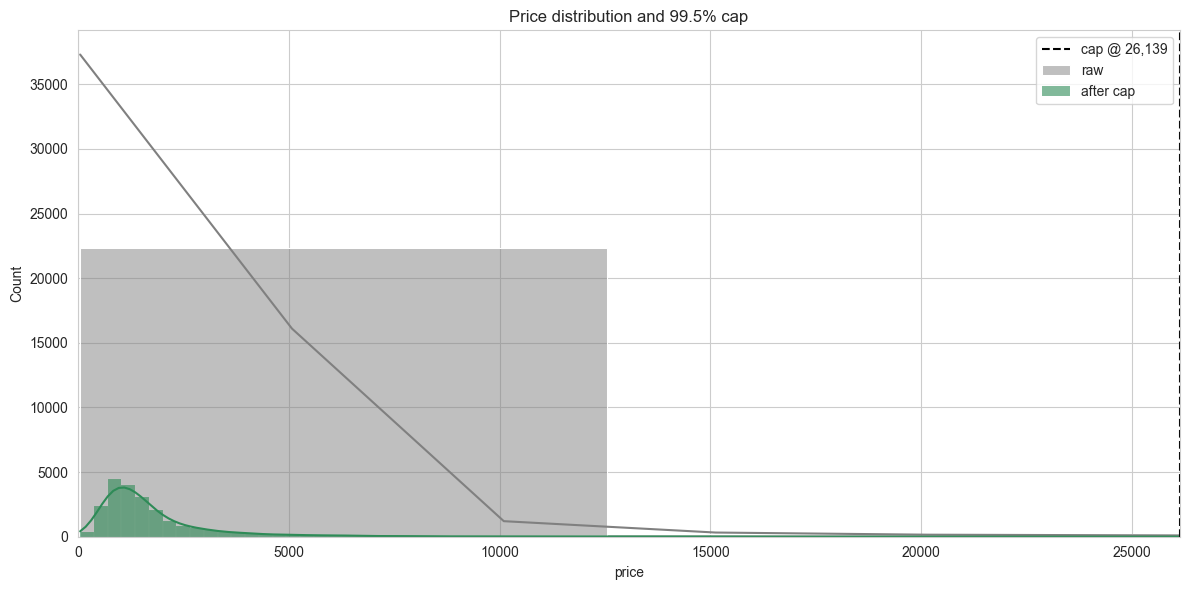

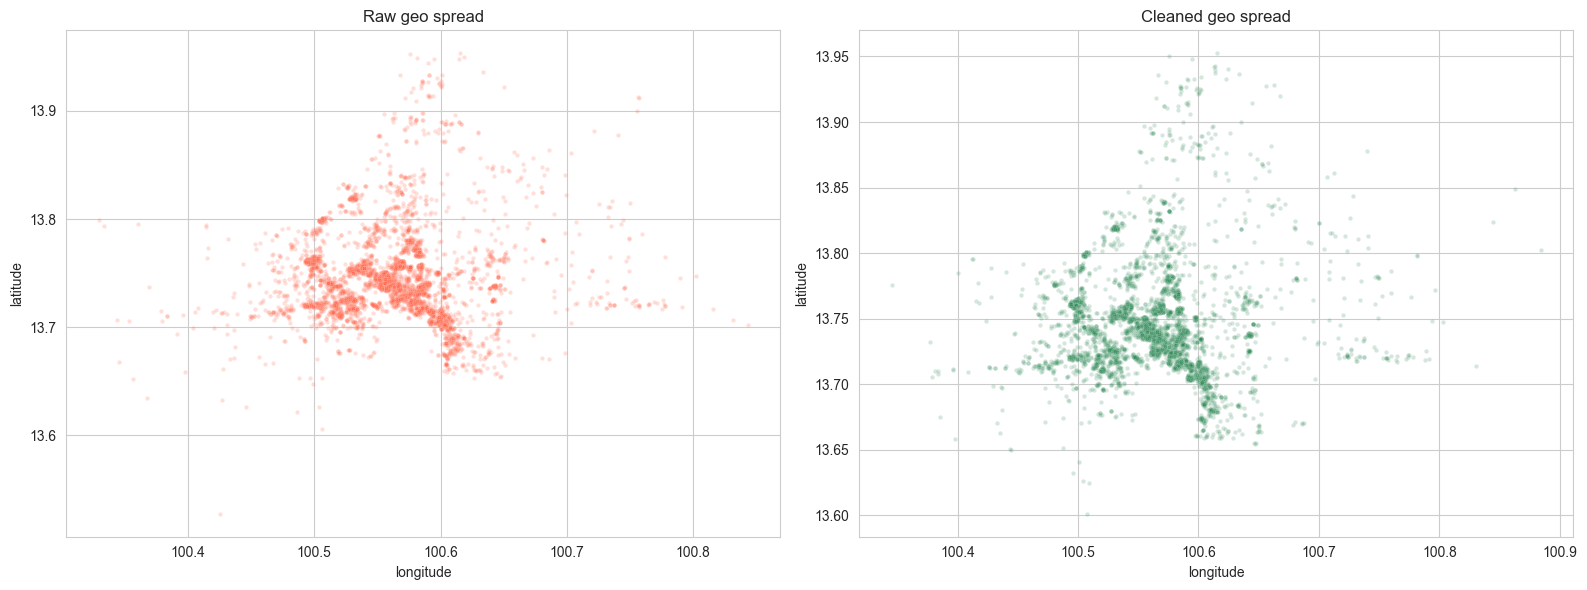

In [8]:
# Compare distributions and missingness before vs after cleaning
viz_cols = [
    'price', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews',
    'review_scores_rating', 'amenities_count'
 ]
viz_cols = [c for c in viz_cols if c in df_raw.columns and c in df.columns]
if len(viz_cols) < 7:
    print("Warning: some viz columns missing in June data; using available subset:", viz_cols)

# Prepare a lightly processed "raw" view (numeric casts but no filtering)
raw_subset = df_raw.copy()
raw_subset['price'] = raw_subset['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)
raw_subset['bathrooms'] = raw_subset['bathrooms_text'].apply(clean_bathrooms) if 'bathrooms_text' in raw_subset.columns else np.nan
if 'amenities' in raw_subset.columns:
    raw_subset['amenities_count'] = raw_subset['amenities'].apply(
        lambda x: 0 if pd.isna(x) else len(x.split(','))
    )
raw_subset = raw_subset[viz_cols].replace([np.inf, -np.inf], np.nan)

clean_subset = df[viz_cols].copy()

# Distribution shifts
fig, axes = plt.subplots(len(viz_cols), 2, figsize=(16, 3 * len(viz_cols)))
for i, col in enumerate(viz_cols):
    sns.histplot(raw_subset[col].dropna(), ax=axes[i, 0], kde=True, color='tomato')
    axes[i, 0].set_title(f"{col}: raw")
    sns.histplot(clean_subset[col].dropna(), ax=axes[i, 1], kde=True, color='seagreen')
    axes[i, 1].set_title(f"{col}: cleaned")
plt.tight_layout()
plt.show()

# Missingness delta
missing_raw = raw_subset.isna().mean().rename('missing_rate_raw')
missing_clean = clean_subset.isna().mean().rename('missing_rate_clean')
missing_compare = pd.concat([missing_raw, missing_clean], axis=1).reset_index().rename(columns={'index': 'feature'})
missing_compare = missing_compare.sort_values('missing_rate_raw', ascending=False)
ax = missing_compare.plot(x='feature', kind='bar', figsize=(12, 6), color=['tomato', 'seagreen'])
ax.set_ylabel('Missing rate')
ax.set_xlabel('Feature')
ax.set_title('Missingness before vs after cleaning')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top categories stability
cat_cols = ['room_type', 'property_type']
fig, axes = plt.subplots(len(cat_cols), 2, figsize=(16, 5 * len(cat_cols)))
for i, col in enumerate(cat_cols):
    top_raw = df_raw[col].value_counts().nlargest(8).index
    sns.countplot(data=df_raw[df_raw[col].isin(top_raw)], y=col, order=top_raw, ax=axes[i, 0], color='tomato')
    axes[i, 0].set_title(f"{col}: raw (top 8)")
    top_clean = df[col].value_counts().nlargest(8).index
    sns.countplot(data=df[df[col].isin(top_clean)], y=col, order=top_clean, ax=axes[i, 1], color='seagreen')
    axes[i, 1].set_title(f"{col}: cleaned (top 8)")
plt.tight_layout()
plt.show()

# Price cap effect (raw vs capped)
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(raw_subset['price'], bins=80, kde=True, color='gray', label='raw', alpha=0.5, ax=ax)
sns.histplot(clean_subset['price'], bins=80, kde=True, color='seagreen', label='after cap', alpha=0.6, ax=ax)
ax.axvline(price_cap, color='black', linestyle='--', label=f'cap @ {price_cap:,.0f}')
ax.set_xlim(0, np.percentile(raw_subset['price'].dropna(), 99.5))
ax.set_title('Price distribution and 99.5% cap')
ax.legend()
plt.tight_layout()
plt.show()

# Location spread (sampled for speed)
sample_n = min(5000, len(df_raw))
raw_sample = df_raw.sample(sample_n, random_state=42)
clean_sample = df.sample(min(sample_n, len(df)), random_state=42)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=raw_sample, x='longitude', y='latitude', alpha=0.2, s=10, ax=axes[0], color='tomato')
axes[0].set_title('Raw geo spread')
sns.scatterplot(data=clean_sample, x='longitude', y='latitude', alpha=0.2, s=10, ax=axes[1], color='seagreen')
axes[1].set_title('Cleaned geo spread')
plt.tight_layout()
plt.show()

--- 
## Phase 2: Data Analysis (DA / EDA)

**Goal:** Explore the cleaned data to understand market trends and price drivers, then turn every insight into a feature for the pricing model.

EDA ↦ Feature Engineering examples:
- Seasonality → create season/holiday indicators
- Spatial price gaps → use neighbourhood dummies or distance-to-POI features
- Size/amenities effects → log(size), amenity counts
- Outliers → cap/winsorize before training

--- Starting Data Analysis Phase ---


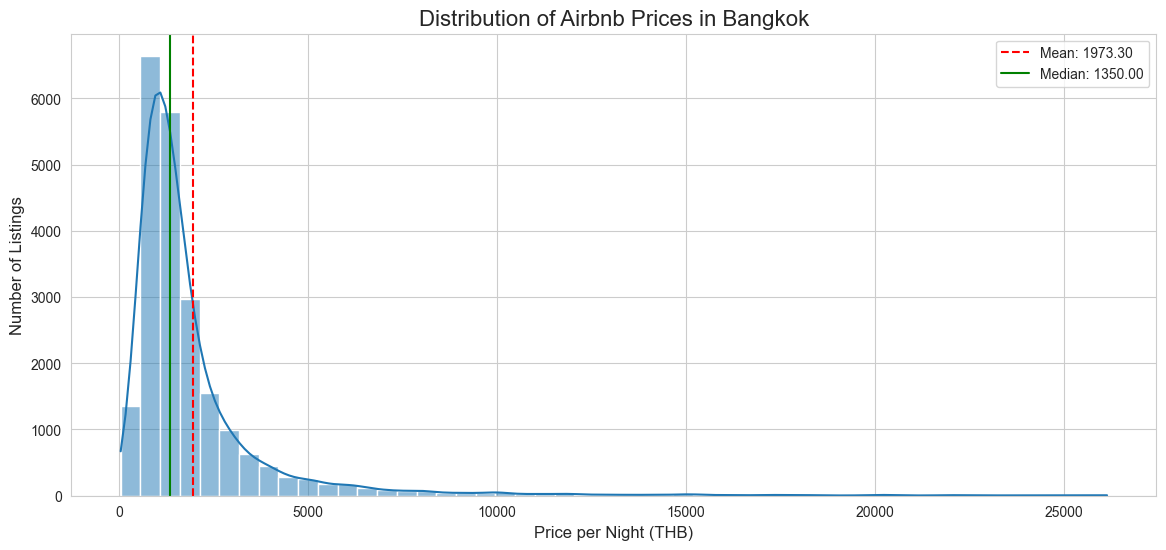

In [9]:
print("--- Starting Data Analysis Phase ---")

# For this phase, we use the cleaned DataFrame 'df' we just created.

# 1. Analyze Price Distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Airbnb Prices in Bangkok', fontsize=16)
plt.xlabel('Price per Night (THB)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f"Mean: {df['price'].mean():.2f}")
plt.axvline(df['price'].median(), color='green', linestyle='-', label=f"Median: {df['price'].median():.2f}")
plt.legend()
plt.show()

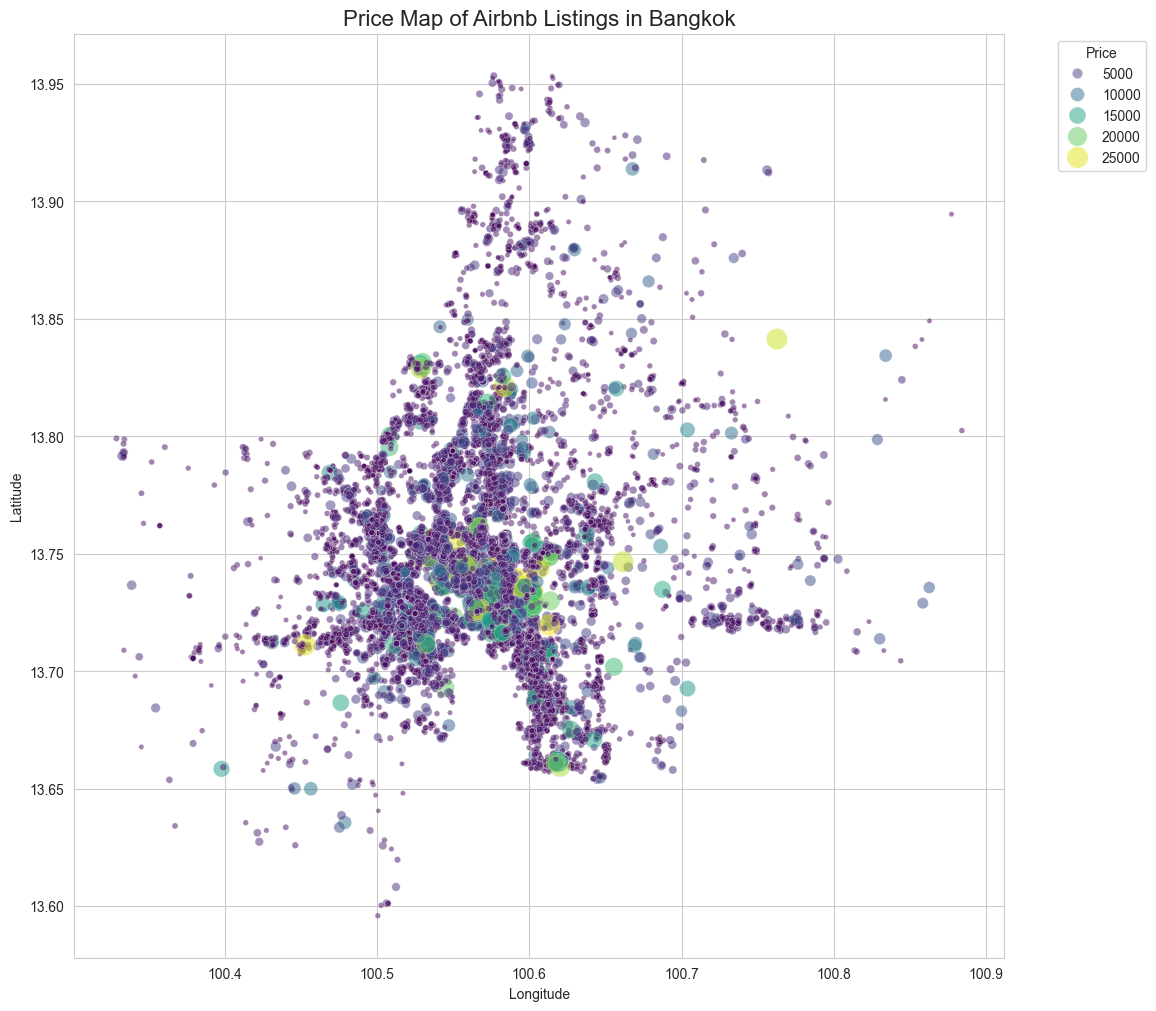

In [10]:
# 2. Geospatial Analysis: Price Hotspots
plt.figure(figsize=(12, 12))
sns.scatterplot(
    data=df,
    x='longitude',
    y='latitude',
    hue='price',
    palette='viridis',
    size='price',
    sizes=(10, 250),
    alpha=0.5
)
plt.title('Price Map of Airbnb Listings in Bangkok', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

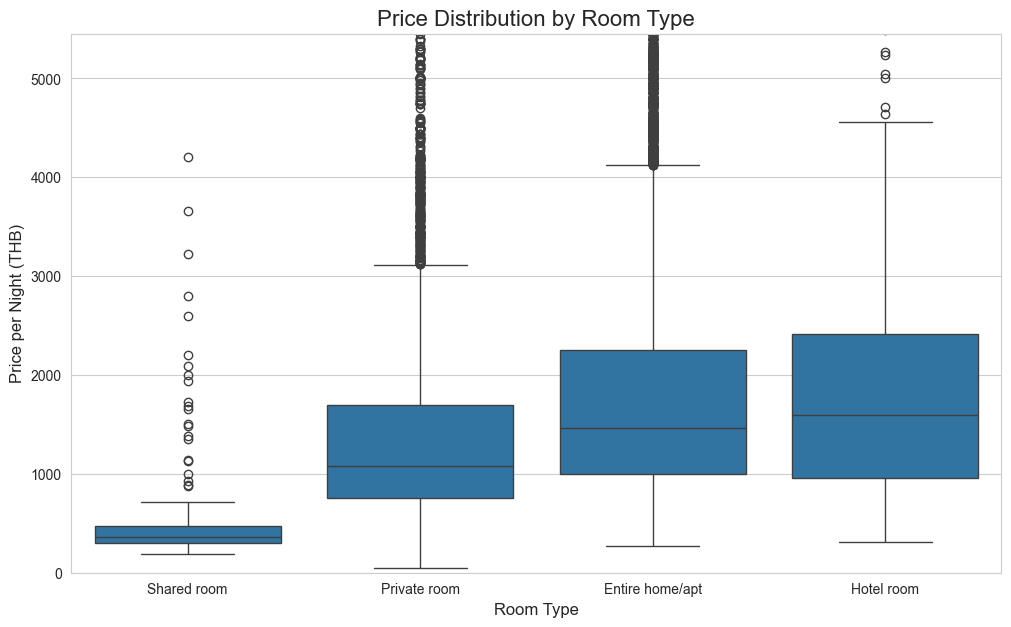

In [11]:
# 3. Categorical Feature Analysis: Price by Room Type
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='room_type', y='price', order=df.groupby('room_type')['price'].median().sort_values().index)
plt.title('Price Distribution by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Price per Night (THB)', fontsize=12)
plt.ylim(0, df['price'].quantile(0.95)) # Zoom in on the bulk of the data
plt.show()

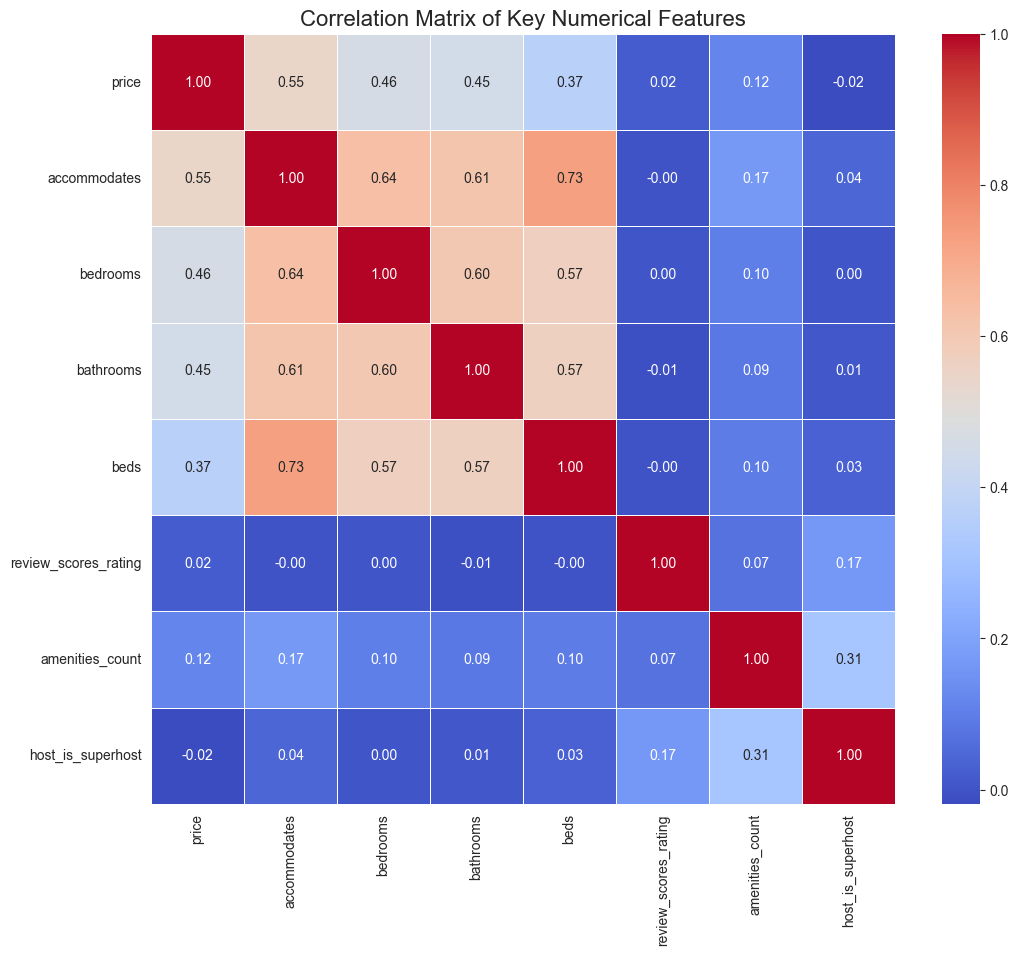

In [12]:
# 4. Correlation Analysis
corr_features = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 'review_scores_rating', 'amenities_count', 'host_is_superhost']
corr_features = [c for c in corr_features if c in df.columns]
if len(corr_features) < 8:
    print("Warning: some correlation features missing in June data; using available subset:", corr_features)

corr_df = df[corr_features].apply(pd.to_numeric, errors='coerce')
corr_matrix = corr_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)
plt.show()

### Additional EDA Highlights

Below are a few complementary perspectives to deepen the understanding of listing quality, pricing outliers, and neighbourhood dynamics.

In [13]:
# Missingness profile for remaining features
missing_pct = (
    df.isna().mean().sort_values(ascending=False) * 100
).rename("missing_pct")
missing_summary = missing_pct[missing_pct > 0].round(2)

if missing_summary.empty:
    print("No missing values detected in the cleaned feature set.")
else:
    display(missing_summary.to_frame())

No missing values detected in the cleaned feature set.


,count,avg_price
neighbourhood,,
Parthum Wan,549,3402.0
Vadhana,3577,2838.0
Lat Phrao,54,2448.0
Nong Chok,9,2304.0
Khlong Toei,2983,2270.0
Bang Bon,11,2267.0
Khlong Sam Wa,27,2262.0
Pom Prap Sattru Phai,178,2196.0
Wang Thong Lang,125,2140.0


/var/folders/b6/28cdp6ds16786vjhx3pz3jlr0000gn/T/ipykernel_10880/2515233955.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


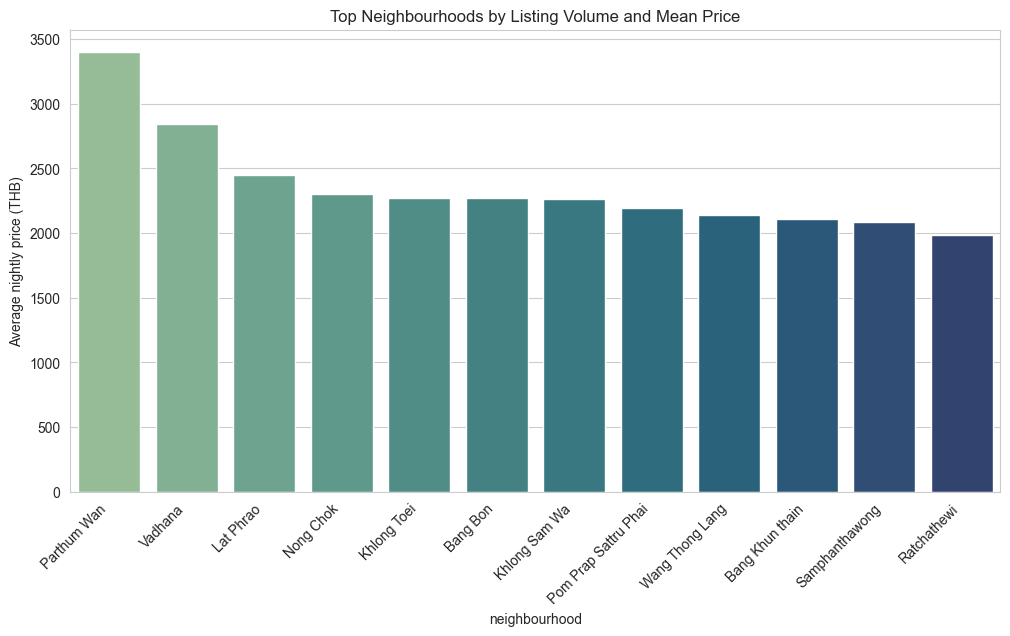

In [14]:
# Neighbourhood performance snapshot
neighbourhood_stats = (
    df.groupby("neighbourhood")
    .agg(count=("id", "size"), avg_price=("price", "mean"))
    .sort_values("avg_price", ascending=False)
    .head(12)
    .assign(avg_price=lambda t: t["avg_price"].round(0))
)

display(neighbourhood_stats)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=neighbourhood_stats.reset_index(),
    x="neighbourhood",
    y="avg_price",
    palette="crest"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average nightly price (THB)")
plt.title("Top Neighbourhoods by Listing Volume and Mean Price")
plt.show()

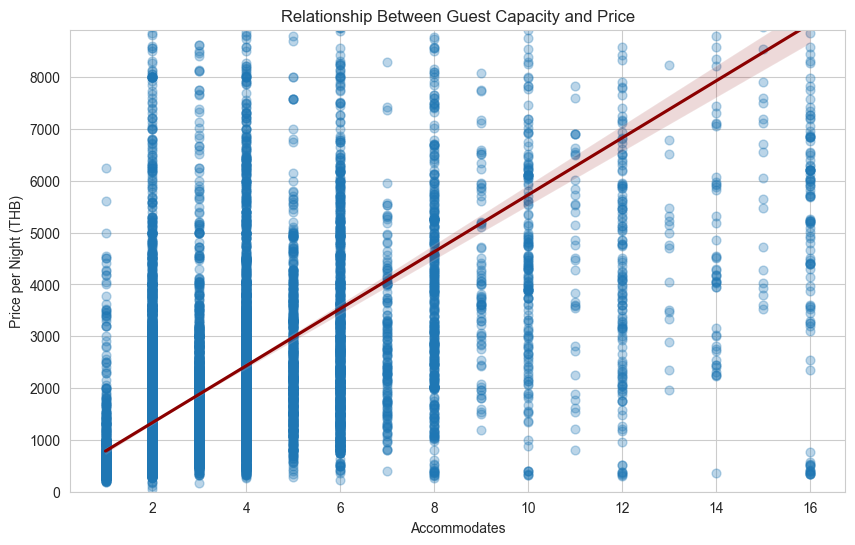

In [15]:
# Capacity versus price with trend line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="accommodates",
    y="price",
    scatter_kws={"alpha": 0.3, "s": 40},
    line_kws={"color": "darkred"},
)
plt.ylim(0, df["price"].quantile(0.98))
plt.title("Relationship Between Guest Capacity and Price")
plt.xlabel("Accommodates")
plt.ylabel("Price per Night (THB)")
plt.show()

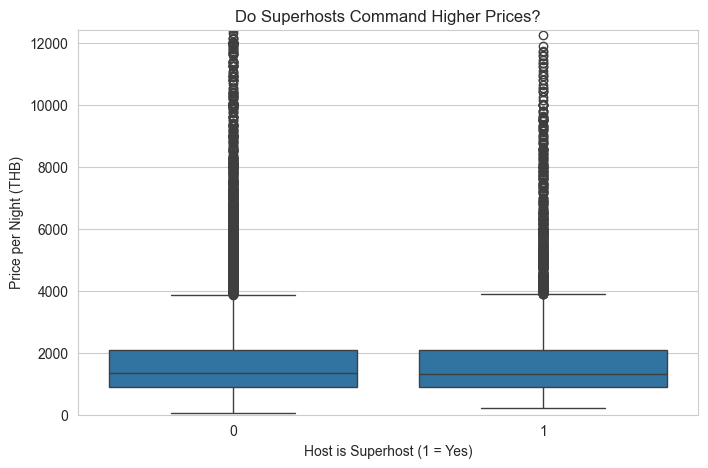

,median_price
host_is_superhost_num,
0,1359.0
1,1316.0


In [16]:
# Superhost premium check
host_col = 'host_is_superhost'
if host_col in df.columns:
    host_vals = pd.to_numeric(df[host_col], errors='coerce')
    df_plot = df.assign(host_is_superhost_num=host_vals)
    df_plot = df_plot.dropna(subset=['host_is_superhost_num', 'price'])
    order_vals = sorted(df_plot['host_is_superhost_num'].unique())
    if len(order_vals) == 0:
        print('No valid host_is_superhost values to plot.')
    else:
        plt.figure(figsize=(8, 5))
        sns.boxplot(
            data=df_plot,
            x='host_is_superhost_num',
            y='price',
            order=order_vals,
        )
        plt.ylim(0, df_plot['price'].quantile(0.99))
        plt.xlabel('Host is Superhost (1 = Yes)')
        plt.ylabel('Price per Night (THB)')
        plt.title('Do Superhosts Command Higher Prices?')
        plt.show()

        price_gap = (
            df_plot.groupby('host_is_superhost_num')['price'].median().rename('median_price')
        )
        display(price_gap.to_frame())
else:
    print('host_is_superhost column not found in df')

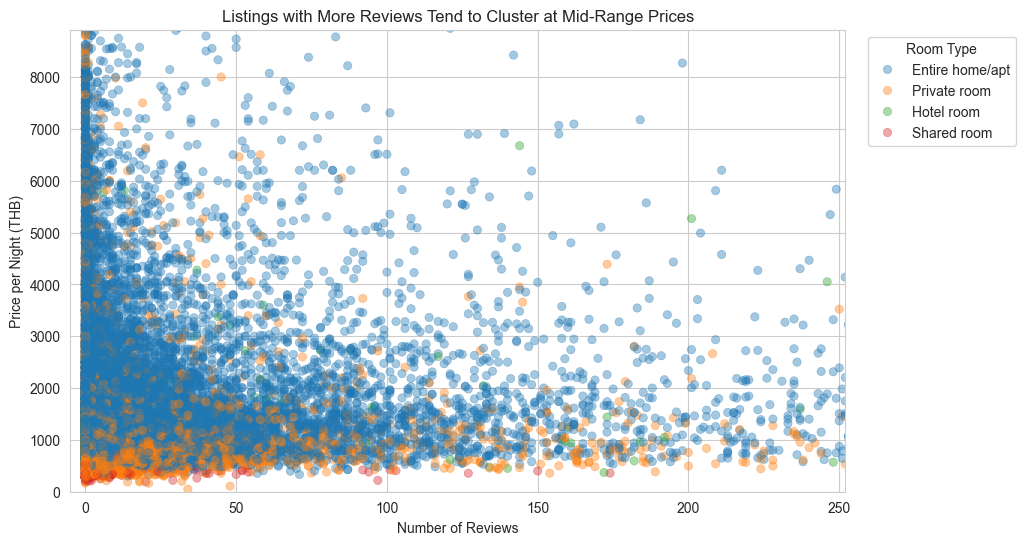

In [17]:
# Demand proxy: reviews momentum vs price
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="number_of_reviews",
    y="price",
    hue="room_type",
    palette="tab10",
    alpha=0.4,
    edgecolor=None,
)
plt.ylim(0, df["price"].quantile(0.98))
plt.xlim(-5, df["number_of_reviews"].quantile(0.99))
plt.xlabel("Number of Reviews")
plt.ylabel("Price per Night (THB)")
plt.title("Listings with More Reviews Tend to Cluster at Mid-Range Prices")
plt.legend(title="Room Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

### Baseline Pricing Heuristics (for comparison)

Baselines are simple, host-realistic rules (no complex model):
- Median/mean price of nearby similar listings (same neighbourhood + property type)
- Median/mean price within neighbourhood for the same room_type
- Simple regression using location + size as signals

Model performance will be compared against these heuristics using the same metrics.

--- 
## Phase 3: Data Science (DS)

**Goal:** Build and evaluate a model that predicts the recommended nightly price (log-price as target), not occupancy.

Metrics:
- MAPE: proportionate pricing error (easy to explain to hosts)
- RMSE: absolute error in THB, sensitive to large misses
We report both to balance interpretability and numeric accuracy.

In [18]:
print("--- Starting Data Science Phase ---")

# --- 1. Feature Preparation ---
print("Preparing features for modeling...")

# Using the log-transformed price can often improve model performance for skewed data
df['log_price'] = np.log1p(df['price'])

y = df['log_price']
X = df.drop(['id', 'price', 'log_price'], axis=1)

# Identify categorical and numerical features for the model pipeline
categorical_features = ['neighbourhood', 'property_type', 'room_type']
base_numerical_features = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating',
    'host_is_superhost', 'latitude', 'longitude', 'amenities_count', 'number_of_reviews',
    'log_amenities_count', 'log_number_of_reviews', 'beds_per_guest', 'bedrooms_per_guest',
    'bathrooms_per_guest', 'amenities_per_guest', 'bathrooms_per_bedroom',
    'lat_centered', 'lon_centered'
 ]
optional_numerical_features = [
    'booked_rate_90', 'median_price_90', 'price_cv_90', 'weekend_price_ratio',
    'review_count_90', 'review_count_365', 'days_since_last_review',
    'host_total_listings_count', 'minimum_nights', 'maximum_nights',
    'review_scores_mean', 'review_scores_std', 'high_rating_flag', 'cleanliness_minus_overall',
    'amenities_detail_count', 'peak_month_booked_rate', 'booked_rate_std_monthly'
 ]
# Keep only optional columns that exist and have at least one non-missing value
available_optional = [c for c in optional_numerical_features if c in df.columns and df[c].notna().any()]

# Only keep base numericals that exist in df (some may be absent in June data)
base_numerical_features = [c for c in base_numerical_features if c in df.columns]

numerical_features = base_numerical_features + available_optional

# Coerce numeric columns to numeric to avoid imputer errors on strings
for col in numerical_features:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Clean categorical columns as strings
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype(str)

# Ensure X only contains the features we will use
present_feature_cols = [c for c in categorical_features + numerical_features if c in X.columns]
missing = set(categorical_features + numerical_features) - set(present_feature_cols)
if missing:
    print("Warning: dropping missing features:", sorted(missing))
X = X[present_feature_cols]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 2. Model Definition & (cached) Training ---
print("Setting up pipeline and checking for cached model...")
MODEL_PATH = 'price_model.joblib'

# Define transformers (impute numerics, impute+encode categoricals)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep other columns if any
 )

# Simple regressor (moderate size to keep training fast)
regressor = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
 )

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

if os.path.exists(MODEL_PATH):
    print(f"Loading cached model from {MODEL_PATH}...")
    trained_model = joblib.load(MODEL_PATH)
else:
    print("Cached model not found; training now...")
    trained_model = model_pipeline.fit(X_train, y_train)
    joblib.dump(trained_model, MODEL_PATH)
    print(f"Model trained and saved to {MODEL_PATH}.")

print("Model ready. Proceed to evaluation...")
params_used = regressor.get_params()
print("Key hyperparameters used:")
for k in ['n_estimators', 'max_depth', 'max_features', 'min_samples_split', 'min_samples_leaf']:
    print(f"  {k}: {params_used.get(k)}")

--- Starting Data Science Phase ---
Preparing features for modeling...
Training data shape: (17667, 39)
Testing data shape: (4417, 39)
Setting up pipeline and checking for cached model...
Loading cached model from price_model.joblib...
Model ready. Proceed to evaluation...
Key hyperparameters used:
  n_estimators: 300
  max_depth: None
  max_features: 1.0
  min_samples_split: 2
  min_samples_leaf: 1


### Feature Groups and Rationale
- Property: type, size, bedrooms/bathrooms, amenities → captures listing capacity/quality
- Location: neighbourhood, latitude/longitude (centered) → spatial willingness-to-pay
- Demand proxies: number_of_reviews, superhost flag → market confidence signals
- Market context: amenity density and per-guest ratios → relative value vs similar listings
Future extensions: calendar signals (weekday/season/holiday) and neighbourhood median price features for stronger market alignment.

In [19]:
# --- 2. Build and Train a Simple Model Pipeline (fast) ---
print("Building a fast model pipeline (no hyperparameter search)...")

# Preprocessing pipeline for numerical data: impute missing values with the median
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing pipeline for categorical data: impute and then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep other columns if any
 )

# Simple regressor (moderate size to keep training fast)
regressor = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
 )

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

model_pipeline.fit(X_train, y_train)
trained_model = model_pipeline
print("Model training complete (no CV search).")

print("Proceed to evaluation on the hold-out set...")

params_used = regressor.get_params()
print("Key hyperparameters used:")
for k in ['n_estimators', 'max_depth', 'max_features', 'min_samples_split', 'min_samples_leaf']:
    print(f"  {k}: {params_used.get(k)}")

Building a fast model pipeline (no hyperparameter search)...
Model training complete (no CV search).
Proceed to evaluation on the hold-out set...
Key hyperparameters used:
  n_estimators: 300
  max_depth: None
  max_features: 1.0
  min_samples_split: 2
  min_samples_leaf: 1


In [20]:
# --- 3. Evaluate the Model ---
print("Evaluating model performance on the test set...")

PRED_CACHE = 'outputs/preds_holdout.parquet'
os.makedirs('outputs', exist_ok=True)

# Use cached predictions if available and index-aligned; otherwise compute and cache
use_cache = False
if os.path.exists(PRED_CACHE):
    try:
        pred_cache = pd.read_parquet(PRED_CACHE)
        if set(pred_cache['index']) == set(X_test.index):
            pred_cache = pred_cache.set_index('index').loc[X_test.index]
            y_pred_actual = pred_cache['y_pred_actual'].to_numpy()
            y_pred_log = np.log1p(y_pred_actual)
            use_cache = True
            print("Loaded cached hold-out predictions.")
    except Exception as e:
        print(f"Skipping cache due to read/shape issue: {e}")

if not use_cache:
    # Make predictions on the test set (they will be in log scale)
    y_pred_log = trained_model.predict(X_test)
    y_pred_actual = np.expm1(y_pred_log)
    pd.DataFrame({
        'index': X_test.index,
        'y_pred_actual': y_pred_actual,
    }).to_parquet(PRED_CACHE, index=False)
    print("Computed and cached hold-out predictions.")

# Inverse transform predictions and actual values to the original price scale
y_test_actual = np.expm1(y_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
r2 = r2_score(y_test_actual, y_pred_actual)
train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(trained_model.predict(X_train))))

print(f"\nModel Performance on hold-out set:")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f} THB")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f} %")
print(f"  - R-squared (R²): {r2:.4f}")
print(f"  - Mean Absolute Error (MAE): {mae:.2f} THB")
print(f"  - Training RMSE (for reference): {train_rmse:.2f} THB")

# --- 4. Save the Model ---
MODEL_PATH = 'price_model.joblib'
print(f"\nSaving the trained model to {MODEL_PATH}...")
joblib.dump(trained_model, MODEL_PATH)
print("Model saved successfully.")

Evaluating model performance on the test set...
Skipping cache due to read/shape issue: 'y_pred_actual'
Computed and cached hold-out predictions.

Model Performance on hold-out set:
  - Root Mean Squared Error (RMSE): 1454.60 THB
  - Mean Absolute Percentage Error (MAPE): 27.05 %
  - R-squared (R²): 0.6112
  - Mean Absolute Error (MAE): 575.77 THB
  - Training RMSE (for reference): 701.12 THB

Saving the trained model to price_model.joblib...
Model saved successfully.


### Backtest: 5-fold cross-validation
Estimate generalization error with shuffled K-Folds using the same pipeline. Metrics are reported on the original price scale (THB). Note: this may take a bit longer than the single train/test split.

In [21]:
# 5-fold shuffled CV backtest (predictions back on THB scale)
from sklearn.model_selection import KFold, cross_val_predict

print("Running 5-fold cross-validation... (this may take a bit)\n")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# cross_val_predict returns predictions in log-price space because y is log_price
cv_pred_log = cross_val_predict(trained_model, X, y, cv=cv, n_jobs=-1)
cv_pred_price = np.expm1(cv_pred_log)
actual_price = np.expm1(y)

cv_rmse = np.sqrt(mean_squared_error(actual_price, cv_pred_price))
cv_mae = mean_absolute_error(actual_price, cv_pred_price)
cv_mape = mean_absolute_percentage_error(actual_price, cv_pred_price) * 100
cv_r2 = r2_score(actual_price, cv_pred_price)

print("5-fold CV metrics (price scale):")
print(f"  - RMSE: {cv_rmse:.2f} THB")
print(f"  - MAE:  {cv_mae:.2f} THB")
print(f"  - MAPE: {cv_mape:.2f} %")
print(f"  - R²:   {cv_r2:.4f}")

Running 5-fold cross-validation... (this may take a bit)

5-fold CV metrics (price scale):
  - RMSE: 1393.31 THB
  - MAE:  564.22 THB
  - MAPE: 26.79 %
  - R²:   0.6252


### Market benchmark: median comparable prices
Compare the model against simple market heuristics (medians from training data). Fallbacks: neighbourhood+property+room → neighbourhood+room → neighbourhood → global median.

In [22]:
# Market heuristics for reliability: medians from training data with fallbacks
print("Building market median benchmarks (train set only)...")

# Train-set prices and categories
train_prices = df.loc[X_train.index].copy()
test_prices = df.loc[X_test.index, 'price']

group_cols = ['neighbourhood', 'property_type', 'room_type']
median_g3 = train_prices.groupby(group_cols)['price'].median()
median_g2 = train_prices.groupby(['neighbourhood', 'room_type'])['price'].median()
median_g1 = train_prices.groupby(['neighbourhood'])['price'].median()
global_median = train_prices['price'].median()

def lookup_median(row):
    key3 = (row['neighbourhood'], row['property_type'], row['room_type'])
    val = median_g3.get(key3, np.nan)
    if pd.isna(val):
        key2 = (row['neighbourhood'], row['room_type'])
        val = median_g2.get(key2, np.nan)
    if pd.isna(val):
        val = median_g1.get(row['neighbourhood'], np.nan)
    if pd.isna(val):
        val = global_median
    return val

baseline_pred = X_test.apply(lookup_median, axis=1)

bench_rmse = np.sqrt(mean_squared_error(test_prices, baseline_pred))
bench_mae = mean_absolute_error(test_prices, baseline_pred)
bench_mape = mean_absolute_percentage_error(test_prices, baseline_pred) * 100
bench_r2 = r2_score(test_prices, baseline_pred)

print("Market median benchmark (price scale):")
print(f"  - RMSE: {bench_rmse:.2f} THB")
print(f"  - MAE:  {bench_mae:.2f} THB")
print(f"  - MAPE: {bench_mape:.2f} %")
print(f"  - R²:   {bench_r2:.4f}")

# Quick comparison vs model's hold-out performance
print("\nModel vs benchmark (lower error is better):")
print(f"  Benchmark RMSE {bench_rmse:.0f} vs Model RMSE {rmse:.0f}")
print(f"  Benchmark MAPE {bench_mape:.1f}% vs Model MAPE {mape:.1f}%")

Building market median benchmarks (train set only)...
Market median benchmark (price scale):
  - RMSE: 2096.88 THB
  - MAE:  927.45 THB
  - MAPE: 42.78 %
  - R²:   0.1920

Model vs benchmark (lower error is better):
  Benchmark RMSE 2097 vs Model RMSE 1455
  Benchmark MAPE 42.8% vs Model MAPE 27.1%


### Peer-based backtest on June hold-out
Compare our model’s suggested prices against peer medians built from similar listings (neighbourhood, property/room type, beds, bedrooms, bathrooms, amenities bucket). This checks if we are proposing sensible prices relative to nearby comps.

In [23]:
# Backtest against peer median pricing on the hold-out set (cached/downsampled for speed)
print("Running peer-based backtest on hold-out (June data)...")
print("Step 0/6: trying cached predictions, else downsampled predict...")

PRED_CACHE = "outputs/preds_holdout.parquet"
os.makedirs("outputs", exist_ok=True)
model_price_series = None

# Try to reuse cached hold-out predictions (must have model_price column and matching index)
if os.path.exists(PRED_CACHE):
    try:
        pred_cache = pd.read_parquet(PRED_CACHE)
        if "model_price" in pred_cache.columns and "index" in pred_cache.columns:
            cached_idx = pred_cache["index"]
            if set(cached_idx) == set(X_test.index):
                print("Loaded cached hold-out predictions.")
                model_price_series = pred_cache.set_index("index")["model_price"].loc[X_test.index]
            else:
                print("Cache index mismatch with current hold-out; recomputing...")
        else:
            print("Cache missing required columns; recomputing...")
    except Exception as e:
        print(f"Cache load failed ({e}); recomputing...")

# If no cache, run on a capped sample for speed
if model_price_series is None:
    sample_n = min(5000, len(X_test))
    sample_idx = (
        X_test.sample(sample_n, random_state=42).index
        if len(X_test) > sample_n
        else X_test.index
    )
    print(f"Predicting on {len(sample_idx):,} rows (of {len(X_test):,})...")
    X_sub = X.loc[sample_idx].copy()
    if "host_is_superhost" in X_sub.columns and X_sub["host_is_superhost"].notna().sum() == 0:
        X_sub["host_is_superhost"] = 0
    model_price_series = pd.Series(
        np.expm1(trained_model.predict(X_sub)),
        index=sample_idx,
        name="model_price",
    )
    try:
        pd.DataFrame({"index": model_price_series.index, "model_price": model_price_series.values}).to_parquet(PRED_CACHE, index=False)
        print(f"Saved cached predictions to {PRED_CACHE} (size={len(model_price_series):,}).")
    except Exception as e:
        print(f"Warning: could not save cache ({e}).")

# Build evaluation frame on the predicted subset
test_eval = df.loc[model_price_series.index].copy()
test_eval["actual_price"] = np.expm1(y.loc[model_price_series.index])
test_eval["model_price"] = model_price_series.values

print("Step 1/6: bucketing amenities...")
amenity_bins = [-1, 5, 15, 30, 50, np.inf]
amenity_labels = ["<=5", "6-15", "16-30", "31-50", "50+"]
test_eval["amenities_bucket"] = pd.cut(
    test_eval["amenities_count"].fillna(0),
    bins=amenity_bins,
    labels=amenity_labels,
 )

print("Step 2/6: building peer medians...")
peer_group_cols = [
    "neighbourhood", "property_type", "room_type", "bedrooms", "beds", "bathrooms", "amenities_bucket"
 ]
peer_available_cols = [c for c in peer_group_cols if c in test_eval.columns]
peer_median = (
    test_eval.groupby(peer_available_cols, observed=True)["actual_price"].transform("median")
    if peer_available_cols
    else pd.Series(dtype=float)
 )
global_median = test_eval["actual_price"].median()
test_eval["peer_median_price"] = peer_median.fillna(global_median)

print("Step 3/6: computing errors...")
test_eval["abs_err_model"] = (test_eval["model_price"] - test_eval["actual_price"]).abs()
test_eval["abs_err_peer"] = (test_eval["peer_median_price"] - test_eval["actual_price"]).abs()
model_rmse = np.sqrt(((test_eval["model_price"] - test_eval["actual_price"]) ** 2).mean())
peer_rmse = np.sqrt(((test_eval["peer_median_price"] - test_eval["actual_price"]) ** 2).mean())
model_mae = test_eval["abs_err_model"].mean()
peer_mae = test_eval["abs_err_peer"].mean()
model_mape = mean_absolute_percentage_error(test_eval["actual_price"], test_eval["model_price"]) * 100
peer_mape = mean_absolute_percentage_error(test_eval["actual_price"], test_eval["peer_median_price"]) * 100

print("Peer-based backtest (cached/downsampled):")
print(f"  Model RMSE: {model_rmse:,.1f} vs Peer RMSE: {peer_rmse:,.1f}")
print(f"  Model MAE : {model_mae:,.1f} vs Peer MAE : {peer_mae:,.1f}")
print(f"  Model MAPE: {model_mape:,.1f}% vs Peer MAPE: {peer_mape:,.1f}%")
print(f"  Share priced below peer median: {(test_eval['model_price'] <= test_eval['peer_median_price']).mean():.2%}")
print(f"  Median pct diff vs peer: {((test_eval['model_price'] - test_eval['peer_median_price']) / test_eval['peer_median_price']).median():.2%}")

print("Step 4/6: showing sample comps...")
comparison_cols = peer_available_cols + [
    "actual_price", "model_price", "peer_median_price", "abs_err_model", "abs_err_peer"
 ]
display(test_eval[comparison_cols].sort_values("abs_err_model").head(10))

print("Done.")

Running peer-based backtest on hold-out (June data)...
Step 0/6: trying cached predictions, else downsampled predict...
Cache missing required columns; recomputing...
Predicting on 4,417 rows (of 4,417)...
Saved cached predictions to outputs/preds_holdout.parquet (size=4,417).
Step 1/6: bucketing amenities...
Step 2/6: building peer medians...
Step 3/6: computing errors...
Peer-based backtest (cached/downsampled):
  Model RMSE: 1,454.6 vs Peer RMSE: 794.5
  Model MAE : 575.8 vs Peer MAE : 283.2
  Model MAPE: 27.1% vs Peer MAPE: 16.4%
  Share priced below peer median: 46.66%
  Median pct diff vs peer: 2.11%
Step 4/6: showing sample comps...


,neighbourhood,property_type,room_type,bedrooms,beds,bathrooms,amenities_bucket,actual_price,model_price,peer_median_price,abs_err_model,abs_err_peer
21194,Bang Sue,Entire condo,Entire home/apt,1.0,1.0,1.0,16-30,665.0,665.000000,665.0,2.307843e-11,0.0
19777,Bang Sue,Entire condo,Entire home/apt,1.0,1.0,1.0,16-30,665.0,665.000000,665.0,2.307843e-11,0.0
17752,Huai Khwang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,16-30,1073.0,1073.043074,1245.0,4.307403e-02,172.0
17246,Huai Khwang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,6-15,1235.0,1234.916740,1500.0,8.325994e-02,265.0
13047,Saphan Sung,Private room in rental unit,Private room,1.0,1.0,1.0,31-50,321.0,321.108969,321.0,1.089685e-01,0.0
16532,Suanluang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,16-30,741.0,740.885185,1024.0,1.148153e-01,283.0
1357,Bang Rak,Entire rental unit,Entire home/apt,1.0,1.0,1.0,50+,1387.0,1386.876793,1415.5,1.232069e-01,28.5
17539,Phra Nakhon,Shared room in hostel,Shared room,1.0,1.0,0.5,16-30,282.0,282.205895,282.0,2.058954e-01,0.0
9994,Lat Krabang,Room in hotel,Private room,1.0,1.0,1.0,6-15,1499.0,1498.764560,1400.0,2.354396e-01,99.0
9995,Lat Krabang,Room in hotel,Private room,1.0,1.0,1.0,6-15,1499.0,1498.764560,1400.0,2.354396e-01,99.0


Done.


### Booking likelihood proxy (demand backtest)
Train a quick classifier to predict whether a listing sits in the high booking-rate bucket (e.g., booked_rate_90 ≥ 0.6). This gives a confidence signal alongside price.

In [24]:
# Booking proxy (leakage-safe): drop proxies + group-aware split
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

# Label: high booked_rate_90 (proxy)
if 'booked_rate_90' not in df.columns:
    print('Skip: booked_rate_90 not available.')
else:
    y_demand = (df['booked_rate_90'] >= 0.6).astype(int)

    # Drop direct/near-proxy calendar features to reduce leakage
    proxy_cols = [
        'booked_rate_90','avail_rate_90','median_price_90','price_cv_90','weekend_price_ratio'
    ]

    # Feature sets
    demand_cat = [c for c in ['neighbourhood','property_type','room_type'] if c in df.columns]
    demand_num = [
        'accommodates','bedrooms','beds','bathrooms','amenities_count','log_amenities_count',
        'log_number_of_reviews','beds_per_guest','bedrooms_per_guest','bathrooms_per_guest',
        'amenities_per_guest','bathrooms_per_bedroom','lat_centered','lon_centered',
        'number_of_reviews','review_scores_rating','host_is_superhost',
        'review_count_90','review_count_365','days_since_last_review','host_total_listings_count',
        'minimum_nights','maximum_nights','review_scores_mean','review_scores_std',
        'high_rating_flag','cleanliness_minus_overall','amenities_detail_count'
    ]
    demand_num = [c for c in demand_num if c in df.columns and c not in proxy_cols]

    X_demand = df[demand_cat + demand_num].copy()

    # Group-aware split: ensure same listing id does not appear in both train/test
    groups = df['id'] if 'id' in df.columns else np.arange(len(df))
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X_demand, y_demand, groups=groups))
    Xd_train, Xd_test = X_demand.iloc[train_idx], X_demand.iloc[test_idx]
    yd_train, yd_test = y_demand.iloc[train_idx], y_demand.iloc[test_idx]

    # Pipeline
    num_pipe = SimpleImputer(strategy='median')
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    demand_pre = ColumnTransformer([
        ('num', num_pipe, demand_num),
        ('cat', cat_pipe, demand_cat)
    ])
    clf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    )
    demand_pipe = Pipeline([
        ('prep', demand_pre),
        ('clf', clf)
    ])

    demand_pipe.fit(Xd_train, yd_train)
    pr = demand_pipe.predict_proba(Xd_test)[:, 1]
    roc = roc_auc_score(yd_test, pr)
    pr_auc = average_precision_score(yd_test, pr)
    acc = accuracy_score(yd_test, (pr >= 0.5).astype(int))

    print('Leakage-safe booking proxy metrics:')
    print('  ROC-AUC: {:.3f}'.format(roc))
    print('  PR-AUC:  {:.3f} (class prevalence {:.2f})'.format(pr_auc, yd_test.mean()))
    print('  Accuracy: {:.3f} @0.5 threshold'.format(acc))


Leakage-safe booking proxy metrics:
  ROC-AUC: 0.841
  PR-AUC:  0.758 (class prevalence 0.35)
  Accuracy: 0.774 @0.5 threshold


--- 
## Phase 4: Inference - Price Recommendation

**Goal:** To use the saved model to predict the price for a new, hypothetical Airbnb listing.

In [25]:
print("--- Starting Inference Phase ---")

# Load the trained model from disk
print(f"Loading model from {MODEL_PATH}...")
loaded_model = joblib.load(MODEL_PATH)

# Optional feature set to mirror training (only those with data)
optional_feature_cols = [
    c for c in [
        'booked_rate_90', 'median_price_90', 'price_cv_90', 'weekend_price_ratio',
        'review_count_90', 'review_count_365', 'days_since_last_review',
        'host_total_listings_count', 'minimum_nights', 'maximum_nights',
        'review_scores_mean', 'review_scores_std', 'high_rating_flag', 'cleanliness_minus_overall',
        'amenities_detail_count', 'peak_month_booked_rate', 'booked_rate_std_monthly'
    ]
    if c in df.columns and df[c].notna().any()
]
optional_defaults = {c: df[c].median() for c in optional_feature_cols}
feature_order = X.columns  # matches training pipeline

# Minimal required raw fields for a user listing submission
required_fields = [
    'neighbourhood', 'property_type', 'room_type',
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'review_scores_rating', 'host_is_superhost',
    'latitude', 'longitude'
]
# Helpful numeric defaults for optional-but-useful columns
numeric_default_fields = ['number_of_reviews', 'amenities_count']
numeric_defaults = {c: df[c].median() for c in numeric_default_fields if c in df.columns}

# Helper: prepare a single listing dict with validation and defaults
def prepare_listing(listing_dict):
    missing = [f for f in required_fields if f not in listing_dict]
    if missing:
        raise ValueError(f"Missing required fields: {missing}")
    row = dict(listing_dict)
    for col, val in numeric_defaults.items():
        row.setdefault(col, val)
    return row

# Helper: add engineered features and fill optional columns
def add_derived_features(raw_df):
    df_feat = raw_df.copy()

    # Derive amenities_count from an amenities string if not provided
    if 'amenities_count' not in df_feat.columns and 'amenities' in df_feat.columns:
        df_feat['amenities_count'] = df_feat['amenities'].apply(
            lambda x: 0 if pd.isna(x) else len(str(x).split(','))
        )

    # Base engineered ratios/logs
    df_feat['log_amenities_count'] = np.log1p(df_feat['amenities_count'])
    df_feat['log_number_of_reviews'] = np.log1p(df_feat['number_of_reviews'].clip(lower=0))
    accommodates_safe = df_feat['accommodates'].replace({0: np.nan})
    bedrooms_safe = df_feat['bedrooms'].replace({0: np.nan})
    df_feat['beds_per_guest'] = df_feat['beds'] / accommodates_safe
    df_feat['bedrooms_per_guest'] = df_feat['bedrooms'] / accommodates_safe
    df_feat['bathrooms_per_guest'] = df_feat['bathrooms'] / accommodates_safe
    df_feat['amenities_per_guest'] = df_feat['amenities_count'] / accommodates_safe
    df_feat['bathrooms_per_bedroom'] = df_feat['bathrooms'] / bedrooms_safe
    df_feat['lat_centered'] = df_feat['latitude'] - LAT_MEAN
    df_feat['lon_centered'] = df_feat['longitude'] - LON_MEAN

    # Optional enrichment defaults (demand/quality/context)
    for col, default_val in optional_defaults.items():
        if col not in df_feat.columns:
            df_feat[col] = default_val
        else:
            df_feat[col] = df_feat[col].fillna(default_val)

    # Ensure categorical columns exist
    for cat_col in ['neighbourhood', 'property_type', 'room_type']:
        if cat_col not in df_feat.columns:
            df_feat[cat_col] = 'Unknown'

    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df_feat

# Predict price for a user-provided listing dict
def predict_listing_price(listing_dict):
    prepared = prepare_listing(listing_dict)
    user_df = pd.DataFrame([prepared])
    enriched = add_derived_features(user_df)
    enriched = enriched.reindex(columns=feature_order, fill_value=np.nan)
    pred_log = loaded_model.predict(enriched)
    return float(np.expm1(pred_log)[0])

# Predict prices for multiple listings at once
def predict_listings(listing_dicts):
    rows = [prepare_listing(d) for d in listing_dicts]
    user_df = pd.DataFrame(rows)
    enriched = add_derived_features(user_df)
    enriched = enriched.reindex(columns=feature_order, fill_value=np.nan)
    pred_log = loaded_model.predict(enriched)
    preds = np.expm1(pred_log)
    result = user_df.copy()
    result['recommended_price'] = preds
    return result

# Example: hypothetical new listing (edit values or swap the dict to your own input)
hypothetical_listing = {
    'neighbourhood': 'Vadhana',  # categorical
    'property_type': 'Entire rental unit',
    'room_type': 'Entire home/apt',
    'accommodates': 4,
    'bedrooms': 2.0,
    'beds': 2.0,
    'bathrooms': 2.0,
    'review_scores_rating': 4.9,
    'host_is_superhost': 1,
    'latitude': 13.7309,
    'longitude': 100.5815,
    'amenities_count': 25,
    'number_of_reviews': 50,
    # Optional enrichments (leave out to use market medians):
    # 'booked_rate_90': 0.65,
    # 'median_price_90': 1800,
    # 'review_scores_mean': 4.85,
    # 'amenities_detail_count': 30,
    # 'peak_month_booked_rate': 0.8,
    # 'booked_rate_std_monthly': 0.1,
}

print("\nNew listing details (raw inputs):")
print(pd.Series(hypothetical_listing))

predicted_price = predict_listing_price(hypothetical_listing)
print("\n-------------------------------------------------")
print(f"==> Recommended Price: {predicted_price:.2f} THB per night <==")
print("(Optional enrichment fields use market medians when omitted.)")

--- Starting Inference Phase ---
Loading model from price_model.joblib...

New listing details (raw inputs):
neighbourhood                      Vadhana
property_type           Entire rental unit
room_type                  Entire home/apt
accommodates                             4
bedrooms                               2.0
beds                                   2.0
bathrooms                              2.0
review_scores_rating                   4.9
host_is_superhost                        1
latitude                           13.7309
longitude                         100.5815
amenities_count                         25
number_of_reviews                       50
dtype: object

-------------------------------------------------
==> Recommended Price: 3086.73 THB per night <==
(Optional enrichment fields use market medians when omitted.)


In [26]:
# Backtest against peer median pricing on the hold-out set (cached or downsampled for speed)
print("Running peer-based backtest on hold-out (June data)...")
print("Step 0/6: try cached preds, else fast predict on a sample...")

PRED_CACHE = "outputs/preds_holdout.parquet"
os.makedirs("outputs", exist_ok=True)
model_price_series = None

# Attempt to reuse cached predictions
if os.path.exists(PRED_CACHE):
    try:
        pred_cache = pd.read_parquet(PRED_CACHE)
        if {"index", "model_price"}.issubset(pred_cache.columns) and set(pred_cache["index"]) == set(X_test.index):
            print("Loaded cached hold-out predictions.")
            model_price_series = pred_cache.set_index("index")["model_price"].loc[X_test.index]
        else:
            print("Cache mismatch; recomputing...")
    except Exception as e:
        print(f"Cache load failed ({e}); recomputing...")

# If no cache, run a capped sample for speed
if model_price_series is None:
    sample_n = min(2000, len(X_test))
    sample_idx = (
        X_test.sample(sample_n, random_state=42).index
        if len(X_test) > sample_n
        else X_test.index
    )
    print(f"Predicting on {len(sample_idx):,} rows (of {len(X_test):,})...")
    X_eval = X.loc[sample_idx].copy()
    if "host_is_superhost" in X_eval.columns and X_eval["host_is_superhost"].notna().sum() == 0:
        X_eval["host_is_superhost"] = 0
    preds_log = trained_model.predict(X_eval)
    model_price_series = pd.Series(np.expm1(preds_log), index=sample_idx, name="model_price")
    try:
        pd.DataFrame({"index": model_price_series.index, "model_price": model_price_series.values}).to_parquet(PRED_CACHE, index=False)
        print(f"Saved cached predictions to {PRED_CACHE} (size={len(model_price_series):,}).")
    except Exception as e:
        print(f"Warning: could not save cache ({e}).")
else:
    sample_idx = model_price_series.index

print("Step 1/6: building eval frames...")
X_eval = X.loc[sample_idx]
y_eval = y.loc[sample_idx]
test_eval = df.loc[sample_idx].copy()
test_eval["actual_price"] = np.expm1(y_eval)
test_eval["model_price"] = model_price_series.loc[sample_idx].values

print("Step 2/6: bucketing amenities and peers...")
amenity_bins = [-1, 5, 15, 30, 50, np.inf]
amenity_labels = ["<=5", "6-15", "16-30", "31-50", "50+"]
test_eval["amenities_bucket"] = pd.cut(
    test_eval["amenities_count"].fillna(0),
    bins=amenity_bins,
    labels=amenity_labels,
 )

peer_group_cols = [
    "neighbourhood",
    "property_type",
    "room_type",
    "bedrooms",
    "beds",
    "bathrooms",
    "amenities_bucket",
 ]
peer_available_cols = [c for c in peer_group_cols if c in test_eval.columns]
peer_median = (
    test_eval.groupby(peer_available_cols, observed=True)["actual_price"].transform("median")
    if peer_available_cols
    else pd.Series(dtype=float)
 )
global_median = test_eval["actual_price"].median()
test_eval["peer_median_price"] = peer_median.fillna(global_median)

print("Step 3/6: computing errors...")
test_eval["abs_err_model"] = (test_eval["model_price"] - test_eval["actual_price"]).abs()
test_eval["abs_err_peer"] = (test_eval["peer_median_price"] - test_eval["actual_price"]).abs()
model_rmse = np.sqrt(((test_eval["model_price"] - test_eval["actual_price"]) ** 2).mean())
peer_rmse = np.sqrt(((test_eval["peer_median_price"] - test_eval["actual_price"]) ** 2).mean())
model_mae = test_eval["abs_err_model"].mean()
peer_mae = test_eval["abs_err_peer"].mean()
model_mape = mean_absolute_percentage_error(test_eval["actual_price"], test_eval["model_price"]) * 100
peer_mape = mean_absolute_percentage_error(test_eval["actual_price"], test_eval["peer_median_price"]) * 100

print("Peer-based backtest (cached/downsampled):")
print(f"  Model RMSE: {model_rmse:,.1f} vs Peer RMSE: {peer_rmse:,.1f}")
print(f"  Model MAE : {model_mae:,.1f} vs Peer MAE : {peer_mae:,.1f}")
print(f"  Model MAPE: {model_mape:,.1f}% vs Peer MAPE: {peer_mape:,.1f}%")
print(f"  Share priced below peer median: {(test_eval['model_price'] <= test_eval['peer_median_price']).mean():.2%}")
print(f"  Median pct diff vs peer: {((test_eval['model_price'] - test_eval['peer_median_price']) / test_eval['peer_median_price']).median():.2%}")

print("Step 4/6: showing sample comps...")
comparison_cols = peer_available_cols + [
    "actual_price", "model_price", "peer_median_price", "abs_err_model", "abs_err_peer"
 ]
display(test_eval[comparison_cols].sort_values("abs_err_model").head(10))

print("Done.")

Running peer-based backtest on hold-out (June data)...
Step 0/6: try cached preds, else fast predict on a sample...
Loaded cached hold-out predictions.
Step 1/6: building eval frames...
Step 2/6: bucketing amenities and peers...
Step 3/6: computing errors...
Peer-based backtest (cached/downsampled):
  Model RMSE: 1,454.6 vs Peer RMSE: 794.5
  Model MAE : 575.8 vs Peer MAE : 283.2
  Model MAPE: 27.1% vs Peer MAPE: 16.4%
  Share priced below peer median: 46.66%
  Median pct diff vs peer: 2.11%
Step 4/6: showing sample comps...


,neighbourhood,property_type,room_type,bedrooms,beds,bathrooms,amenities_bucket,actual_price,model_price,peer_median_price,abs_err_model,abs_err_peer
21194,Bang Sue,Entire condo,Entire home/apt,1.0,1.0,1.0,16-30,665.0,665.000000,665.0,2.307843e-11,0.0
19777,Bang Sue,Entire condo,Entire home/apt,1.0,1.0,1.0,16-30,665.0,665.000000,665.0,2.307843e-11,0.0
17752,Huai Khwang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,16-30,1073.0,1073.043074,1245.0,4.307403e-02,172.0
17246,Huai Khwang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,6-15,1235.0,1234.916740,1500.0,8.325994e-02,265.0
13047,Saphan Sung,Private room in rental unit,Private room,1.0,1.0,1.0,31-50,321.0,321.108969,321.0,1.089685e-01,0.0
16532,Suanluang,Entire rental unit,Entire home/apt,1.0,1.0,1.0,16-30,741.0,740.885185,1024.0,1.148153e-01,283.0
1357,Bang Rak,Entire rental unit,Entire home/apt,1.0,1.0,1.0,50+,1387.0,1386.876793,1415.5,1.232069e-01,28.5
17539,Phra Nakhon,Shared room in hostel,Shared room,1.0,1.0,0.5,16-30,282.0,282.205895,282.0,2.058954e-01,0.0
9994,Lat Krabang,Room in hotel,Private room,1.0,1.0,1.0,6-15,1499.0,1498.764560,1400.0,2.354396e-01,99.0
9995,Lat Krabang,Room in hotel,Private room,1.0,1.0,1.0,6-15,1499.0,1498.764560,1400.0,2.354396e-01,99.0


Done.


In [27]:
# Compare June vs September listings: new IDs and value changes on overlapping IDs
import pandas as pd
import os

def pick_file(name_options, base_dir):
    for name in name_options:
        candidate = os.path.join(base_dir, name)
        if os.path.exists(candidate):
            return candidate
    raise FileNotFoundError(f"None of {name_options} found under {base_dir}")

def read_csv_auto(path):
    return pd.read_csv(path, low_memory=False, compression="gzip" if path.endswith('.gz') else None)

def normalize_id(df):
    if "listing_id" in df.columns:
        col = "listing_id"
    elif "id" in df.columns:
        col = "id"
    else:
        raise KeyError("Neither 'listing_id' nor 'id' found in dataframe")
    out = df.rename(columns={col: "listing_id"}).copy()
    out["listing_id"] = out["listing_id"].astype(str).str.strip()
    out = out[out["listing_id"].notna()]
    return out

# Load data
june_path = pick_file(["listings.csv.gz", "listings.csv"], base_dir="data/jun")
sep_path = pick_file(["listings.csv.gz", "listings.csv"], base_dir="data/sep")
june_df = normalize_id(read_csv_auto(june_path))
sep_df = normalize_id(read_csv_auto(sep_path))

# Drop duplicate IDs within each dataset
june_df = june_df.drop_duplicates(subset=["listing_id"])
sep_df = sep_df.drop_duplicates(subset=["listing_id"])

june_ids = set(june_df["listing_id"])
sep_ids = set(sep_df["listing_id"])
new_ids = sep_ids - june_ids

new_listings_df = sep_df[sep_df["listing_id"].isin(new_ids)].copy()

print(f"June listings: {len(june_ids):,}")
print(f"September listings: {len(sep_ids):,}")
print(f"New listings in September not in June: {len(new_ids):,}")
if len(new_ids) == 0 and len(june_ids) == len(sep_ids):
    print("Note: ID sets are identical; the September file may be the same as June or IDs are reused.")

# For overlapping IDs, find value changes
overlap_ids = june_ids & sep_ids
if overlap_ids:
    june_overlap = june_df[june_df["listing_id"].isin(overlap_ids)].set_index("listing_id")
    sep_overlap = sep_df[sep_df["listing_id"].isin(overlap_ids)].set_index("listing_id")
    common_cols = sorted(set(june_overlap.columns) & set(sep_overlap.columns))
    # Exclude ID itself
    if "listing_id" in common_cols:
        common_cols.remove("listing_id")
    # Align
    june_overlap = june_overlap[common_cols]
    sep_overlap = sep_overlap[common_cols]
    # Compute diffs
    diff_mask = (june_overlap != sep_overlap) & ~(june_overlap.isna() & sep_overlap.isna())
    changed_rows = diff_mask.any(axis=1)
    print(f"Overlapping listings: {len(overlap_ids):,}")
    print(f"Listings with any value change: {changed_rows.sum():,}")
    # Column-level change counts
    col_changes = diff_mask.sum().sort_values(ascending=False)
    print("Top changed columns:")
    print(col_changes[col_changes > 0].head(10))
    # Sample a few changed rows
    if changed_rows.sum() > 0:
        sample_changes = june_overlap[changed_rows].head(5).copy()
        sample_changes_sep = sep_overlap.loc[sample_changes.index]
        display(pd.concat({"june": sample_changes, "sep": sample_changes_sep}, axis=1))
else:
    print("No overlapping IDs to compare.")

display(new_listings_df.head())

June listings: 28,196
September listings: 28,196
New listings in September not in June: 0
Note: ID sets are identical; the September file may be the same as June or IDs are reused.
Overlapping listings: 28,196
Listings with any value change: 0
Top changed columns:
Series([], dtype: int64)


,listing_id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [ ]:
# Market Validation: Proof of Concept (Occupancy at Recommended Price)
# [Updated] Fixed Price Band using Log-Normal Distribution to handle outliers

import numpy as np
import pandas as pd
from pathlib import Path

# Config display
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", None)

# --- 1. Setup Input & Get Listing Details ---
# Fallback listing details if hypothetical_listing is not defined
fallback_listing = {
    "neighbourhood": "Pathumwan",
    "bedrooms": 3,
    "bathrooms": 3,
    "price": 5000,
}
listing_input = hypothetical_listing if "hypothetical_listing" in globals() else fallback_listing

# Extract specs
target_area = str(listing_input.get("neighbourhood", "Pathumwan"))
target_bedrooms = float(listing_input.get("bedrooms", 3))
target_bathrooms = float(listing_input.get("bathrooms", 3))
property_type = listing_input.get("property_type", "Apartment")

# Use predicted_price if available, else use input price
target_price = predicted_price if "predicted_price" in globals() else listing_input.get("price", 5000)

print(f"🏠 Your Listing: {target_area} | {target_bedrooms:.0f} Bed | {target_bathrooms:.0f} Bath | {property_type}")
print(f"   Recommended Price (from Model): {target_price:,.0f} THB")
print("-" * 50)

# --- 2. Load calendar window (26 Sep 2025 - 25 Dec 2025) ---
# Function to load calendar safely
def load_calendar(path_candidates):
    for candidate in path_candidates:
        p = Path(candidate)
        if p.exists():
            compression = "gzip" if p.suffix == ".gz" else None
            return pd.read_csv(p, parse_dates=["date"], low_memory=False, compression=compression)
    print(f"⚠️ Warning: Calendar files not found in {path_candidates}. Skipping calendar metrics.")
    return None

calendar_df = load_calendar(["data/sep/calendar.csv", "data/sep/calendar.csv.gz"])
occ_by_listing = pd.DataFrame()

if calendar_df is not None:
    calendar_df["listing_id"] = calendar_df["listing_id"].astype(str).str.strip()
    
    # Filter specific window
    start_date = pd.Timestamp("2025-09-26")
    end_date = pd.Timestamp("2025-12-25")
    calendar_df = calendar_df[(calendar_df["date"] >= start_date) & (calendar_df["date"] <= end_date)].copy()

    # Clean price and check booking status
    calendar_df["is_booked"] = calendar_df["available"].astype(str).str.lower().eq("f")
    calendar_df["price_num"] = pd.to_numeric(
        calendar_df["price"].astype(str).str.replace(r"[\$,]", "", regex=True), errors="coerce"
    )

    # Aggregate by listing
    occ_by_listing = (
        calendar_df.groupby("listing_id")
        .agg(
            nights=("is_booked", "size"),
            booked_nights=("is_booked", "sum"),
            occ_window=("is_booked", "mean"),
            avg_price_window=("price_num", "mean"),
        )
        .reset_index()
    )
    print(f"Calendar window loaded: {len(calendar_df):,} rows | Listings: {occ_by_listing.shape[0]:,}")
    print(f"Window: {start_date.date()} to {end_date.date()}")
else:
    print("Skipping calendar aggregation.")

# --- 3. Define Search Scope (FIXED: Log-Normal Approach) ---
# Calculate Price Range using Log-Space Standard Deviation

# 3.1 Get prices from the same neighbourhood
if 'neighbourhood' in df.columns:
    neigh_prices = df[
        (df['neighbourhood'].astype(str) == target_area) & 
        (df['price'] > 0)
    ]['price'].dropna()
else:
    # Fallback if neighbourhood column missing
    neigh_prices = df[df['price'] > 0]['price'].dropna()

# 3.2 Calculate Log-SD
if len(neigh_prices) > 10:
    # Take Log
    log_prices = np.log1p(neigh_prices)
    log_sd = log_prices.std()
    
    # Take Log of our Target Price
    log_target = np.log1p(target_price)
    
    # Set Range: Target +/- (Multiplier * SD) in Log Space
    # Using 0.6 SD is usually good for finding tight comps without being too narrow
    sd_multiplier = 0.6 
    log_floor = log_target - (log_sd * sd_multiplier)
    log_ceil = log_target + (log_sd * sd_multiplier)
    
    # Convert back to THB (Exponentiate)
    price_floor = np.expm1(log_floor)
    price_ceil = np.expm1(log_ceil)
    
    # Safety Clamp: Ensure range isn't wider than +/- 50% of target (sanity check)
    price_floor = max(price_floor, target_price * 0.5)
    price_ceil = min(price_ceil, target_price * 1.5)
    
    print(f"\n✓ Price Band (Log-Normal): Target {target_price:,.0f} THB")
    print(f"  Neighbourhood Log-SD: {log_sd:.3f} (Multiplier: {sd_multiplier})")
    print(f"  Range: {price_floor:,.0f} - {price_ceil:,.0f} THB")
else:
    # Fallback if not enough data
    margin = 0.2
    price_floor = target_price * (1 - margin)
    price_ceil = target_price * (1 + margin)
    print(f"\n⚠️ Price Band (Fallback): +/- {margin:.0%} (Not enough data for SD)")

# Allow flexible specs (+/- 1 bed/bath)
max_bed_delta = 0
max_bath_delta = 1

# --- 4. Helper: Occupancy Proxy (Fallback) ---
def occupancy_proxy(frame):
    """Calculate Occupancy Rate (0-1) from static data if calendar is missing."""
    if 'peak_month_booked_rate' in frame.columns:
        s = pd.to_numeric(frame['peak_month_booked_rate'], errors='coerce')
        if s.max() > 0: return s.clip(0, 1)
    
    if 'booked_rate_90' in frame.columns:
        s = pd.to_numeric(frame['booked_rate_90'], errors='coerce')
        if s.max() > 0: return s.clip(0, 1)
        
    if 'avail_rate_90' in frame.columns:
        s = pd.to_numeric(frame['avail_rate_90'], errors='coerce')
        if s.notna().any(): return (1 - s).clip(0, 1)
            
    return None

# --- 5. Filtering Comps ---
# Filter by Area
area_mask = df['neighbourhood'].str.contains(target_area, case=False, na=False) if 'neighbourhood' in df.columns else pd.Series(False, index=df.index)
df_area = df[area_mask].copy()

# Filter by Specs (Bed/Bath)
def within_delta(series, target, delta):
    ser = pd.to_numeric(series, errors='coerce')
    return ser.sub(target).abs() <= delta

bed_mask = within_delta(df_area.get('bedrooms', pd.Series(index=df_area.index)), target_bedrooms, max_bed_delta)
bath_mask = within_delta(df_area.get('bathrooms', pd.Series(index=df_area.index)), target_bathrooms, max_bath_delta)

# Filter by Price Range (using the new Log-SD bounds)
price_mask = (df_area['price'] >= price_floor) & (df_area['price'] <= price_ceil) if 'price' in df_area.columns else pd.Series(False, index=df_area.index)

comps = df_area[bed_mask & bath_mask & price_mask].copy()
if 'id' in comps.columns and 'listing_id' not in comps.columns:
    comps.rename(columns={'id': 'listing_id'}, inplace=True)

# Merge with Real Calendar Occupancy
if not occ_by_listing.empty and 'listing_id' in comps.columns:
    comps['listing_id'] = comps['listing_id'].astype(str).str.strip()
    comps = comps.merge(occ_by_listing[['listing_id', 'occ_window', 'avg_price_window']], on='listing_id', how='left')

# Determine Final Occupancy Metric
if 'occ_window' in comps.columns:
    comps['occ_proxy'] = comps['occ_window']
    print(f"✓ Occupancy Source: Calendar Window")
else:
    occ = occupancy_proxy(comps)
    if occ is not None:
        comps['occ_proxy'] = occ
        print(f"✓ Occupancy Source: Proxy Metrics (Static Data)")
    else:
        print("⚠️ Warning: No occupancy data available")

# --- 6. Remove "Zombie Listings" & Sort ---
cols_to_show = ['listing_id', 'neighbourhood', 'property_type', 'room_type', 'bedrooms', 'bathrooms', 'price', 'occ_proxy', 'review_count_90', 'review_scores_rating']


if len(comps) > 0:
    # Zombie Filter: Occ > 99% but 0 reviews in 90 days = Blocked/Inactive
    if 'occ_proxy' in comps.columns and 'review_count_90' in comps.columns:
        comps['review_count_90'] = comps['review_count_90'].fillna(0)
        zombie_mask = (comps['occ_proxy'] >= 0.99) & (comps['review_count_90'] == 0)
        n_zombies = zombie_mask.sum()
        
        if n_zombies > 0:
            comps = comps[~zombie_mask].copy()
            print(f"-> Filtered out {n_zombies} 'zombie' listings (Full calendar but 0 reviews).")

    # Sorting Logic: Occupancy -> Reviews -> Price
    sort_cols = []
    sort_asc = []
    
    if 'occ_proxy' in comps.columns:
        sort_cols.append('occ_proxy')
        sort_asc.append(False) 
    if 'review_count_90' in comps.columns:
        sort_cols.append('review_count_90')
        sort_asc.append(False)
    sort_cols.append('price')
    sort_asc.append(True)

    final_comps = comps.sort_values(sort_cols, ascending=sort_asc)
    
    print(f"\n✅ Found {len(final_comps)} comparable listings.")
    print(f"   In Price Range: {price_floor:,.0f} - {price_ceil:,.0f} THB")
    
    if len(final_comps) > 0:
        avg_occ = final_comps['occ_proxy'].mean() if 'occ_proxy' in final_comps.columns else 0
        print(f"📊 Average Occupancy of Comps: {avg_occ:.1%}")
        
        print("\n🏆 Top Comparable Listings (Active & Similar Price):")
        display_df = final_comps[cols_to_show].copy().head(15)
        
        # Format for display
        if 'occ_proxy' in display_df.columns:
            display_df['occ_proxy'] = display_df['occ_proxy'].map('{:.1%}'.format)
        
        display(display_df)
else:
    print(f"\n⚠️ Market Resistance: No similar listings found in {price_floor:,.0f} - {price_ceil:,.0f} THB.")
    print("   Consider widening the search or checking if the recommended price is realistic.")

🏠 Your Listing: Vadhana | 2 Bed | 2 Bath | Entire rental unit
   Recommended Price (from Model): 3,087 THB
--------------------------------------------------
Calendar window loaded: 2,590,436 rows | Listings: 28,806
Window: 2025-09-26 to 2025-12-25

✓ Price Band (Log-Normal): Target 3,087 THB
  Neighbourhood Log-SD: 0.724 (Multiplier: 0.6)
  Range: 1,998 - 4,630 THB
✓ Occupancy Source: Calendar Window
-> Filtered out 5 'zombie' listings (Full calendar but 0 reviews).

✅ Found 463 comparable listings.
   In Price Range: 1,998 - 4,630 THB
📊 Average Occupancy of Comps: 23.3%

🏆 Top Comparable Listings (Active & Similar Price):


,listing_id,neighbourhood,property_type,room_type,bedrooms,bathrooms,price,occ_proxy,review_count_90,review_scores_rating,avg_price_window
78,41625484,Vadhana,Entire townhouse,Entire home/apt,2.0,2.0,2375.0,100.0%,1.0,4.85,NaN
429,1364128439707897822,Vadhana,Entire condo,Entire home/apt,2.0,2.0,2965.0,100.0%,1.0,5.00,NaN
88,48893198,Vadhana,Room in hotel,Private room,2.0,2.5,3800.0,100.0%,1.0,4.85,NaN
427,1357050107543823777,Vadhana,Entire rental unit,Entire home/apt,2.0,2.0,4000.0,100.0%,1.0,4.85,NaN
462,1441158033050760721,Vadhana,Private room in rental unit,Private room,2.0,1.0,2116.0,98.9%,1.0,4.85,NaN
90,50404732,Vadhana,Entire condo,Entire home/apt,2.0,2.0,2008.0,97.8%,2.0,4.76,NaN
215,1000333457891529690,Vadhana,Entire rental unit,Entire home/apt,2.0,1.0,2506.0,96.7%,1.0,5.00,NaN
455,1430152568674552093,Vadhana,Entire condo,Entire home/apt,2.0,2.0,2517.0,95.6%,1.0,5.00,NaN
8,7664777,Vadhana,Entire rental unit,Entire home/apt,2.0,2.5,2953.0,95.6%,1.0,4.91,NaN
56,34980129,Vadhana,Entire condo,Entire home/apt,2.0,1.0,2235.0,95.6%,0.0,5.00,NaN
